In [0]:
"""
Notebook de vérification et préparation des fichiers de simulation pour la maintenance prédictive.

Ce notebook effectue un contrôle qualité exhaustif et une réorganisation des fichiers CSV 
de simulation issus de différents scénarios de défaillance. Il vérifie l'intégrité des données,
détecte les anomalies, réorganise les fichiers et assure une nomenclature cohérente pour
l'analyse ultérieure. Il effectue les opérations suivantes :

1. **Vérification des temps de simulation courts** :
   - Parcours de 13 dossiers de défauts : CC_T, Compresseur, Fuite_Fuel, Noise_TOT, etc.
   - Détection des fichiers avec dernière valeur Time ≤ 200.3s, 300.3s, 400.3s, 600.3s
   - Identification des simulations longues (Time ≥ 8000s)
   - Statistiques par dossier : nombre de fichiers, Time min/max observé
   - Affichage des fichiers problématiques pour suppression ultérieure

2. **Analyse des critères d'arrêt des simulations** :
   - Extraction des valeurs finales : Beta_Comp, Beta_Turb, T_rec_h_in
   - Création de tableaux récapitulatifs par dossier avec ID simulation
   - Tri par numéro de simulation avec regex avancée (Sim_xxx_YYY)
   - Affichage formaté avec pandas DataFrame pour chaque dossier
   - Gestion des colonnes manquantes et erreurs de lecture

3. **Visualisation des critères d'arrêt (spaghetti plots)** :
   - Critères globaux : Beta_Comp < 0.14, Beta_Turb < 0.1, T_rec_h_in > 1023.15
   - Tracé optimisé avec lecture sélective des colonnes (usecols)
   - Filtrage Time > 0 pour éviter les artefacts
   - Lignes de seuil en rouge pour identifier les dépassements
   - Un graphique par critère et par dossier (12x3 = 36 graphiques)

4. **Répartition des fichiers Defaut_Tuyaux** :
   - Séparation du dossier global en 4 sous-dossiers par type de fuite
   - Mapping par préfixe : comp_rec, cc_t, rec_cc, turb_rec
   - Création automatique des dossiers cibles avec makedirs
   - Copie avec shutil.copy2 (préserve métadonnées)
   - Rapport : fichiers copiés vs non reconnus

5. **Vérification de la continuité des identifiants (hors Mix)** :
   - Pattern regex : Sim_(\d+)_ pour extraire les numéros
   - Détection des trous dans la séquence 1, 2, 3...
   - Renommage automatique pour assurer la continuité
   - Conservation du reste du nom de fichier
   - 8 dossiers traités : tous sauf Defaut_Mix

6. **Vérification générale incluant Defaut_Mix** :
   - Pattern étendu : Sim(?:Longue)?[_]?(\d+)[_]?
   - Support des formats Sim_xxx et SimLongue_xxx
   - Détection et rapport des discontinuités
   - Alerte spécifique pour les trous détectés
   - Liste complète des numéros manquants

7. **Création de Defaut_Mix_Final avec renommage** :
   - Copie dans nouveau dossier pour préserver originaux
   - Tri par numéro actuel puis réindexation séquentielle
   - Mode simulation pour vérifier avant exécution
   - Gestion séparée Sim_ et SimLongue_ avec préservation préfixe
   - Rapport détaillé : ancien nom → nouveau nom

8. **Suppression du préfixe "Longue" dans SimLongue** :
   - Remplacement SimLongue_ → Sim_ dans Defaut_Mix_Final
   - Vérification existence fichier cible avant renommage
   - Mode simulation/réel contrôlé par variable
   - Conservation de tous les autres éléments du nom
   - Gestion des conflits de noms

9. **Vérification des fichiers Sans_Defaut** :
   - Application du même pattern de vérification
   - Dossier_Sans_Defaut_Final analysé séparément
   - Détection des discontinuités dans la numérotation
   - Rapport OK/ALERTE selon résultat
   - Préparation pour analyse comparative avec défauts

10. **Renommage spécifique des défauts tuyaux** :
    - Pattern complexe : Sim_.*?_(\d{3})_N_ pour format XXX
    - Extraction du numéro à 3 chiffres (padding zeros)
    - Réindexation séquentielle avec format {:03d}
    - Traitement séparé des 4 types de tuyaux
    - Mode simulation avant exécution réelle

11. **Vérification finale des défauts tuyaux** :
    - Extraction et tri de tous les numéros
    - Détection explicite des numéros manquants
    - Rapport détaillé par dossier de tuyaux
    - Validation de la continuité 1→N
    - Alerte si discontinuités persistent

Paramètres globaux :
- BASE_DIR : /Volumes/dbe_dbx_internships/justin/predictive_maintenance/
- 13 dossiers de défauts + 4 sous-dossiers tuyaux
- Seuils temps : [200.3, 300.3, 400.3, 600.3] secondes
- Critères arrêt : Beta_Comp < 0.14, Beta_Turb < 0.1, T_rec_h_in > 1023.15
- Mode simulation : variable pour test avant exécution

Résultats attendus :
- Fichiers courts identifiés pour suppression
- Nomenclature cohérente : Sim_1_, Sim_2_, ..., Sim_N_
- Séparation claire des types de défauts tuyaux
- Tableaux récapitulatifs des critères d'arrêt
- Visualisations pour validation manuelle

"""

1. Vérification des fichiers et temps de simulation

In [0]:
import os
import pandas as pd
import re

BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIERS = [
    "Defaut_CC_T",
    "Defaut_Compresseur",
    "Defaut_Fuite_Fuel",
    "Defaut_Noise_TOT",
    "Defaut_Rec_T",
    "Defaut_Recuperateur",
    "Defaut_Turbine",
    "FiltreAir",
    "Defaut_Mix" ,
    "Defaut_Tuyaux_cc_t",
    "Defaut_Tuyaux_comp_rec",
    "Defaut_Tuyaux_rec_cc",
    "Defaut_Tuyaux_turb_rec"
]

SEUILS = [200.3, 300.3, 400.3, 600.3]

def detecter_fichiers_arret_court_par_dernier_temps(base_dir, dossiers, seuils):
    print("\n===  FICHIERS DONT LA DERNIÈRE VALEUR DE TIME EST ≤ 200.1 / 300.1 / 400.1s ===\n")

    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
            continue

        derniers_temps = []
        nb_csv = 0
        fichiers_time_8000 = []  # pour les fichiers Time >= 8000

        for fichier in os.listdir(path_dossier):
            if not fichier.endswith(".csv"):
                continue

            chemin_fichier = os.path.join(path_dossier, fichier)
            try:
                df = pd.read_csv(chemin_fichier)
                if "Time" not in df.columns or df.empty:
                    continue

                time_last = df["Time"].iloc[-1]
                derniers_temps.append(time_last)
                nb_csv += 1

                if time_last >= 8000.0: # Si Time >= 8000 → on le note
                    fichiers_time_8000.append((fichier, time_last))

                for seuil in seuils:
                    if time_last <= seuil: # Détection temps courts pour les supprimer par après 
                        print(f" {fichier} — Dernier Time : {time_last:.2f}s (≤ {seuil}s) — Dossier : {dossier}")
                        break

            except Exception as e:
                print(f"[ERREUR] {fichier} : {e}")

        if nb_csv > 0 and derniers_temps:
            print(f"\n Statistiques dossier : {dossier}")
            print(f"   → Nombre de fichiers CSV : {nb_csv}")
            print(f"   → Dernier Time min observé : {min(derniers_temps):.2f}s")
            print(f"   → Dernier Time max observé : {max(derniers_temps):.2f}s")

            if fichiers_time_8000:
                print(f"\n[INFO] FICHIERS AVEC TIME >= 8000 DANS {dossier} :")
                for f, t in fichiers_time_8000:
                    print(f" → {f} — Dernier Time : {t:.2f}s")
            else:
                print(f"[OK] Aucun fichier avec Time >= 8000 dans {dossier}.")

            print("\n")  

        else:
            print(f"\n {dossier} : Aucun fichier CSV exploitable.\n")

detecter_fichiers_arret_court_par_dernier_temps(BASE_DIR, DOSSIERS, SEUILS)



===  FICHIERS DONT LA DERNIÈRE VALEUR DE TIME EST ≤ 200.1 / 300.1 / 400.1s ===


 Statistiques dossier : Defaut_CC_T
   → Nombre de fichiers CSV : 101
   → Dernier Time min observé : 1950.90s
   → Dernier Time max observé : 3911.90s
[OK] Aucun fichier avec Time >= 8000 dans Defaut_CC_T.



 Statistiques dossier : Defaut_Compresseur
   → Nombre de fichiers CSV : 100
   → Dernier Time min observé : 799.70s
   → Dernier Time max observé : 7525.30s
[OK] Aucun fichier avec Time >= 8000 dans Defaut_Compresseur.



 Statistiques dossier : Defaut_Fuite_Fuel
   → Nombre de fichiers CSV : 99
   → Dernier Time min observé : 700.00s
   → Dernier Time max observé : 2940.00s
[OK] Aucun fichier avec Time >= 8000 dans Defaut_Fuite_Fuel.


 ⏱ Sim_65_N_76.28_TOT_649.74_Tamb_304.43_pamb_0.94_CoefDrift_-0.07398_Kleak_0.00084_NoiseTOT_1_StartTOT_223_NoiseFuel_0_StartFuel_0.csv — Dernier Time : 531.90s (≤ 600.3s) — Dossier : Defaut_Noise_TOT

 Statistiques dossier : Defaut_Noise_TOT
   → Nombre de fichiers

2. Vérification de la valeur des critères d'arrêt à la fin de chaque fichier de simulation dans chaque dossier de défaut

In [0]:
colonnes_resultat = ["ID (Sim_xxx)", "Dernier Time", "Beta_Comp", "Beta_Turb", "T_rec_h_in"] #Colonne à retrouver dans le tableau de synthèse
tables_par_dossier = {}

for dossier in DOSSIERS:
    path_dossier = os.path.join(BASE_DIR, dossier)
    if not os.path.isdir(path_dossier):
        print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
        continue

    fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
    fichiers_csv.sort()

    print(f"\n=== Dossier : {dossier} — {len(fichiers_csv)} fichiers ===")

    resultats = []

    for fichier in fichiers_csv:
        chemin_fichier = os.path.join(path_dossier, fichier)

        try:
            df = pd.read_csv(chemin_fichier)

            match_id = re.search(r"(Sim_[^_]+(?:_[^_]+)*_\d+)_N_", fichier)
            if match_id:
                sim_id = match_id.group(1)
                num_match = re.search(r"_(\d+)$", sim_id)
                if num_match:
                    sim_num = int(num_match.group(1))
                else:
                    sim_num = float('inf')
            else:
                sim_id = fichier.replace(".csv", "")
                sim_num = float('inf')

            if "Time" in df.columns:
                last_time = df["Time"].iloc[-1]
            else:

                df_temp = df.copy()
                df_temp.columns = [col.strip() for col in df_temp.columns]
                first_col_name = df_temp.columns[1]  
                last_time = df_temp[first_col_name].iloc[-1]

            last_beta_comp = df["Beta_Comp"].iloc[-1] if "Beta_Comp" in df.columns else None
            last_beta_turb = df["Beta_Turb"].iloc[-1] if "Beta_Turb" in df.columns else None
            last_t_rec_h_in = df["T_rec_h_in"].iloc[-1] if "T_rec_h_in" in df.columns else None

            resultats.append([
                sim_id,
                last_time,
                last_beta_comp,
                last_beta_turb,
                last_t_rec_h_in,
                sim_num
            ])

        except Exception as e:
            print(f"[ERREUR] {fichier} : {e}")

    if resultats:
        df_resultat = pd.DataFrame(resultats, columns=colonnes_resultat + ["_Sim_num"])
        df_resultat.sort_values(by="_Sim_num", inplace=True)
        df_resultat.reset_index(drop=True, inplace=True)
        df_resultat = df_resultat.drop(columns="_Sim_num")

        tables_par_dossier[dossier] = df_resultat
    else:
        print(f"[INFO] Aucun fichier exploitable pour {dossier}.")

print("\n=== SYNTHÈSE : TABLEAUX PAR DOSSIER ===\n")
for dossier, df_table in tables_par_dossier.items():
    print(f"\n--- {dossier} ---")
    display(df_table)



=== Dossier : Defaut_CC_T — 101 fichiers ===

=== Dossier : Defaut_Compresseur — 100 fichiers ===

=== Dossier : Defaut_Fuite_Fuel — 99 fichiers ===

=== Dossier : Defaut_Noise_TOT — 98 fichiers ===

=== Dossier : Defaut_Rec_T — 100 fichiers ===

=== Dossier : Defaut_Recuperateur — 100 fichiers ===

=== Dossier : Defaut_Turbine — 96 fichiers ===

=== Dossier : FiltreAir — 100 fichiers ===

=== Dossier : Defaut_Mix — 1072 fichiers ===

=== Dossier : Defaut_Tuyaux_cc_t — 98 fichiers ===

=== Dossier : Defaut_Tuyaux_comp_rec — 100 fichiers ===

=== Dossier : Defaut_Tuyaux_rec_cc — 97 fichiers ===

=== Dossier : Defaut_Tuyaux_turb_rec — 100 fichiers ===

=== SYNTHÈSE : TABLEAUX PAR DOSSIER ===


--- Defaut_CC_T ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_100_N_72.05_TOT_559.11_Tamb_279.80_pamb_0.99_perc_fool_CC2T_0.008182_bool_foul_CC_turb_1_start_foul_CC_turb_1685_T_c_out_init_332.7405_T_t_out_init_603.6400_TIT_init_698.3848 3640.7 0.280678543875753 0.0991078621114805 856.907217634179 Sim_74_N_85.89_TOT_608.78_Tamb_299.20_pamb_1.03_perc_fool_CC2T_0.009574_bool_foul_CC_turb_1_start_foul_CC_turb_211_T_c_out_init_348.2895_T_t_out_init_651.3368_TIT_init_757.3250 2166.3 0.142020584506106 0.099821247506305 922.186567265305 Sim_73_N_72.72_TOT_523.84_Tamb_310.14_pamb_0.96_perc_fool_CC2T_0.012603_bool_foul_CC_turb_1_start_foul_CC_turb_1089_T_c_out_init_363.7278_T_t_out_init_738.1479_TIT_init_869.0981 3019.3 0.366509303060052 0.0999376598755496 809.271688030465 Sim_72_N_93.32_TOT_551.29_Tamb_293.82_pamb_0.97_perc_fool_CC2T_0.014264_bool_foul_CC_turb_1_start_foul_CC_turb_529_T_c_out_init_351.6561_T_t_out_init_689.3606_TIT_init_807.4698 2475.3 0.194608759225349 0.0987344630126991 868.444206007114 Sim_71_N_78.35_TOT_632.39_Tamb_301.66_pamb_0.99_perc_fool_CC2T_0.010996_bool_foul_CC_turb_1_start_foul_CC_turb_1684_T_c_out_init_333.7042_T_t_out_init_536.8307_TIT_init_607.8724 3634.7 0.27423493308239 0.0982033736471687 934.760094611066 Sim_70_N_97.81_TOT_541.79_Tamb_298.61_pamb_0.92_perc_fool_CC2T_0.012373_bool_foul_CC_turb_1_start_foul_CC_turb_900_T_c_out_init_320.9464_T_t_out_init_457.9601_TIT_init_505.8795 2849.6 0.37580369996701 0.0996484326652315 860.36511426054 Sim_6_N_92.94_TOT_638.97_Tamb_279.00_pamb_0.90_perc_fool_CC2T_0.011159_bool_foul_CC_turb_1_start_foul_CC_turb_763_T_c_out_init_387.4681_T_t_out_init_938.5969_TIT_init_1131.3494 2712.6 0.139941817003349 0.347187622279894 957.356919822261 Sim_69_N_87.33_TOT_609.32_Tamb_284.44_pamb_0.99_perc_fool_CC2T_0.012889_bool_foul_CC_turb_1_start_foul_CC_turb_1272_T_c_out_init_354.4961_T_t_out_init_728.2729_TIT_init_858.9981 3188.0 0.139888221463283 0.592533681492454 900.227736066459 Sim_68_N_96.70_TOT_553.81_Tamb_301.43_pamb_0.94_perc_fool_CC2T_0.008656_bool_foul_CC_turb_1_start_foul_CC_turb_1152_T_c_out_init_318.7300_T_t_out_init_428.1540_TIT_init_466.4240 3109.0 0.305755575568824 0.0982296694427526 871.274705592067 Sim_67_N_78.94_TOT_530.54_Tamb_280.21_pamb_0.93_perc_fool_CC2T_0.013317_bool_foul_CC_turb_1_start_foul_CC_turb_485_T_c_out_init_348.8071_T_t_out_init_701.0928_TIT_init_824.3017 2428.4 0.276435068374983 0.0987624634428286 829.438680431409 Sim_66_N_90.81_TOT_564.49_Tamb_302.39_pamb_0.90_perc_fool_CC2T_0.009266_bool_foul_CC_turb_1_start_foul_CC_turb_1444_T_c_out_init_345.1688_T_t_out_init_618.5559_TIT_init_714.1707 3391.3 0.139742195842277 0.227069423484694 868.294924250126 Sim_65_N_84.09_TOT_577.35_Tamb_308.95_pamb_0.96_perc_fool_CC2T_0.011055_bool_foul_CC_turb_1_start_foul_CC_turb_922_T_c_out_init_309.0465_T_t_out_init_309.7141_TIT_init_309.9476 2868.1 0.283228287174567 0.0991437490673829 876.898413664007 Sim_64_N_68.96_TOT_633.57_Tamb_305.37_pamb_1.00_perc_fool_CC2T_0.012862_bool_foul_CC_turb_1_start_foul_CC_turb_13_T_c_out_init_335.6067_T_t_out_init_535.3949_TIT_init_605.2691 1955.1 0.25273887566554 0.0998450195974724 925.221413442582 Sim_63_N_69.63_TOT_635.22_Tamb_277.60_pamb_0.99_perc_fool_CC2T_0.008490_bool_foul_CC_turb_1_start_foul_CC_turb_509_T_c_out_init_355.2285_T_t_out_init_744.8772_TIT_init_881.1535 2466.8 0.204293662322411 0.0998014189139661 934.569635313931 Sim_62_N_81.09_TOT_591.48_Tamb_306.92_pamb_1.03_perc_fool_CC2T_0.012592_bool_foul_CC_turb_1_start_foul_CC_turb_1916_T_c_out_init_351.5909_T_t_out_init_652.0612_TIT_init_757.1480 3859.5 0.322173678644193 0.0998432002494564 891.672171972154 Sim_61_N_91.15_TOT_584.69_Tamb_267.69_pamb_0.92_perc_fool_CC2T_0.010023_bool_foul_CC_turb_1_start_foul_CC_turb_880_T_c_out_init_301.1224_T_t_out_init_455.6758_TIT_init_509.7296 2835.0 0.139498939445993 0.2558602258871 906.272395433993 Sim_60_N_92.80_TOT_643.67_Tamb_311.58_pamb_0.94_perc_fool_CC2T_0.008761_bool_foul_CC_turb_1_start_foul_CC_turb_1222_T_c_out_init_354.9221_T


--- Defaut_Compresseur ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_100_N_78.17_TOT_577.28_Tamb_301.93_pamb_0.96_ slope_degradation_0.00007_start_comp_eff_1891_bool_eta_comp_deg_1_T_c_out_init_368.9096_T_t_out_init_794.7868_TIT_init_943.7337 3155.0 0.139982850451922 0.204697003131775 851.989731708593 Sim_75_N_64.39_TOT_512.72_Tamb_283.38_pamb_0.95_ slope_degradation_0.00008_start_comp_eff_1256_bool_eta_comp_deg_1_T_c_out_init_332.5973_T_t_out_init_592.6536_TIT_init_683.6061 2103.3 0.139990820063263 0.131696418604472 786.96568749632 Sim_74_N_85.89_TOT_608.78_Tamb_299.20_pamb_1.03_ slope_degradation_0.00003_start_comp_eff_211_bool_eta_comp_deg_1_T_c_out_init_348.2895_T_t_out_init_651.3368_TIT_init_757.3250 2221.2 0.139999201685207 0.553655435670087 882.865523682901 Sim_73_N_72.72_TOT_523.84_Tamb_310.14_pamb_0.96_ slope_degradation_0.00007_start_comp_eff_1089_bool_eta_comp_deg_1_T_c_out_init_363.7278_T_t_out_init_738.1479_TIT_init_869.0981 2165.3 0.221735866302744 0.0999662900849871 798.034572122006 Sim_72_N_93.32_TOT_551.29_Tamb_293.82_pamb_0.97_ slope_degradation_0.00009_start_comp_eff_529_bool_eta_comp_deg_1_T_c_out_init_351.6561_T_t_out_init_689.3606_TIT_init_807.4698 1590.4 0.139953076832821 0.489441597363771 827.523063984332 Sim_71_N_78.35_TOT_632.39_Tamb_301.66_pamb_0.99_ slope_degradation_0.00005_start_comp_eff_1684_bool_eta_comp_deg_1_T_c_out_init_333.7042_T_t_out_init_536.8307_TIT_init_607.8724 3419.0 0.13997547070895 0.349908269182397 906.7833533299 Sim_70_N_97.81_TOT_541.79_Tamb_298.61_pamb_0.92_ slope_degradation_0.00006_start_comp_eff_900_bool_eta_comp_deg_1_T_c_out_init_320.9464_T_t_out_init_457.9601_TIT_init_505.8795 2807.3 0.139990780775387 0.403073334323942 817.240391751982 Sim_6_N_92.94_TOT_638.97_Tamb_279.00_pamb_0.90_ slope_degradation_0.00005_start_comp_eff_763_bool_eta_comp_deg_1_T_c_out_init_387.4681_T_t_out_init_938.5969_TIT_init_1131.3494 2196.5 0.139974747807281 0.717743150589992 913.92724127713 Sim_69_N_87.33_TOT_609.32_Tamb_284.44_pamb_0.99_ slope_degradation_0.00007_start_comp_eff_1272_bool_eta_comp_deg_1_T_c_out_init_354.4961_T_t_out_init_728.2729_TIT_init_858.9981 1834.3 0.13999960617993 0.700590124324702 884.519985564139 Sim_68_N_96.70_TOT_553.81_Tamb_301.43_pamb_0.94_ slope_degradation_0.00002_start_comp_eff_1152_bool_eta_comp_deg_1_T_c_out_init_318.7300_T_t_out_init_428.1540_TIT_init_466.4240 6802.3 0.139995080284103 0.453382848661619 827.600504065503 Sim_67_N_78.94_TOT_530.54_Tamb_280.21_pamb_0.93_ slope_degradation_0.00008_start_comp_eff_485_bool_eta_comp_deg_1_T_c_out_init_348.8071_T_t_out_init_701.0928_TIT_init_824.3017 1627.2 0.139982901039951 0.299774515663086 805.534554479104 Sim_66_N_90.81_TOT_564.49_Tamb_302.39_pamb_0.90_ slope_degradation_0.00003_start_comp_eff_1444_bool_eta_comp_deg_1_T_c_out_init_345.1688_T_t_out_init_618.5559_TIT_init_714.1707 3471.7 0.139990923548239 0.545023360659807 838.309192575563 Sim_65_N_84.09_TOT_577.35_Tamb_308.95_pamb_0.96_ slope_degradation_0.00005_start_comp_eff_922_bool_eta_comp_deg_1_T_c_out_init_309.0465_T_t_out_init_309.7141_TIT_init_309.9476 2646.3 0.139978646314968 0.299576220561803 851.743198542465 Sim_64_N_68.96_TOT_633.57_Tamb_305.37_pamb_1.00_ slope_degradation_0.00007_start_comp_eff_13_bool_eta_comp_deg_1_T_c_out_init_335.6067_T_t_out_init_535.3949_TIT_init_605.2691 985.5 0.139967278632679 0.263398722752593 907.633085790492 Sim_63_N_69.63_TOT_635.22_Tamb_277.60_pamb_0.99_ slope_degradation_0.00002_start_comp_eff_509_bool_eta_comp_deg_1_T_c_out_init_355.2285_T_t_out_init_744.8772_TIT_init_881.1535 4191.4 0.139992810440644 0.493752766385424 908.680565677244 Sim_62_N_81.09_TOT_591.48_Tamb_306.92_pamb_1.03_ slope_degradation_0.00007_start_comp_eff_1916_bool_eta_comp_deg_1_T_c_out_init_351.5909_T_t_out_init_652.0612_TIT_init_757.1480 3310.1 0.139960449535997 0.220764971733312 866.423113238196 Sim_61_N_91.15_TOT_584.69_Tamb_267.69_pamb_0.92_ slope_degradation_0.00004_start_comp_eff_880_bool_eta_comp_deg_1_T_c_out_init_301.1224_T_t_out_init_455.6758_TIT_ini


--- Defaut_Fuite_Fuel ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_10_N_99.85_TOT_570.91_Tamb_311.71_pamb_1.02_CoefDrift_-0.07636_Kleak_0.00081_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_251 1170.0 0.776134523337845 0.535917689675605 760.623317401898 Sim_75_N_92.57_TOT_548.70_Tamb_309.61_pamb_0.93_CoefDrift_-0.08247_Kleak_0.00091_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_703 1520.0 0.460828192477861 0.534935029116478 780.111341238379 Sim_74_N_87.96_TOT_678.18_Tamb_311.11_pamb_0.92_CoefDrift_-0.08552_Kleak_0.00073_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_508 1525.0 0.379341589433235 0.691090573759777 914.195112392586 Sim_73_N_64.76_TOT_599.67_Tamb_311.14_pamb_0.98_CoefDrift_-0.08329_Kleak_0.00098_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1012 1775.0 0.347907137480663 0.431899362624859 858.704318967004 Sim_72_N_79.59_TOT_589.12_Tamb_295.47_pamb_1.00_CoefDrift_-0.08172_Kleak_0.00094_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_325 1115.0 0.494127335003675 0.60339261084264 830.799503931576 Sim_71_N_87.79_TOT_563.42_Tamb_310.66_pamb_0.96_CoefDrift_-0.07855_Kleak_0.00098_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_373 1130.0 0.463223472228165 0.52264751648151 798.657190953654 Sim_70_N_75.69_TOT_631.10_Tamb_271.71_pamb_0.90_CoefDrift_-0.08169_Kleak_0.00062_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1647 2840.0 0.427988529552413 0.773088635248616 879.160915369694 Sim_6_N_60.73_TOT_636.77_Tamb_302.34_pamb_1.02_CoefDrift_-0.06303_Kleak_0.00091_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_435 1250.0 0.244018648890024 0.446692325320277 896.407335246834 Sim_69_N_91.69_TOT_691.90_Tamb_295.94_pamb_1.01_CoefDrift_-0.06198_Kleak_0.00094_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1487 2280.0 0.363312431853978 0.760495067588172 881.19500795989 Sim_68_N_98.60_TOT_531.52_Tamb_311.68_pamb_0.96_CoefDrift_-0.06599_Kleak_0.00067_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1832 2940.0 0.74924563934539 0.504917086892424 750.138783342613 Sim_67_N_92.59_TOT_681.16_Tamb_269.50_pamb_0.98_CoefDrift_-0.08707_Kleak_0.00074_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1915 2920.0 0.532421118372896 0.786756607717244 805.758573216904 Sim_66_N_87.78_TOT_551.36_Tamb_263.64_pamb_0.94_CoefDrift_-0.06161_Kleak_0.00105_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_49 755.0 0.427285339887739 0.730364908238345 771.660935993772 Sim_65_N_85.82_TOT_524.64_Tamb_288.37_pamb_0.91_CoefDrift_-0.08556_Kleak_0.00070_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_863 1925.0 0.429814164084252 0.576696985059378 765.087804975026 Sim_64_N_85.01_TOT_608.61_Tamb_285.10_pamb_0.97_CoefDrift_-0.06715_Kleak_0.00098_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1496 2255.0 0.367127849805341 0.702870526193252 836.669747001467 Sim_63_N_97.43_TOT_663.74_Tamb_299.56_pamb_0.95_CoefDrift_-0.08434_Kleak_0.00060_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1399 2635.0 0.654060069830422 0.681901972716387 819.889820870525 Sim_62_N_76.15_TOT_609.71_Tamb_265.59_pamb_0.94_CoefDrift_-0.08275_Kleak_0.00072_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1913 2940.0 0.4217785785523 0.767539599652891 853.754528555989 Sim_61_N_77.70_TOT_680.87_Tamb_264.81_pamb_0.99_CoefDrift_-0.08462_Kleak_0.00077_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_644 1610.0 0.350390109122735 0.834266930845568 915.778895905491 Sim_60_N_94.26_TOT_580.49_Tamb_279.05_pamb_1.02_CoefDrift_-0.06273_Kleak_0.00090_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1706 2535.0 0.686898765493206 0.660288718389679 745.546319589676 Sim_5_N_92.18_TOT_697.22_Tamb_264.65_pamb_0.91_CoefDrift_-0.06594_Kleak_0.00109_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1879 2560.0 0.459096208864465 0.846397877757257 865.351878610432 Sim_59_N_87.20_TOT_641.19_Tamb_295.41_pamb_0.93_CoefDrift_-0.06683_Kleak_0.00071_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1782 2820.0 0.353701089216647 0.716870100143615 874.795293400389 Sim_58_N_62.73_TOT_587.27_Tamb_271.84_pamb_1.03_CoefDrift_-0.07708_Kleak_0.00108_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_14 700.0 0.304828298406162 0.61993261


--- Defaut_Noise_TOT ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_10_N_93.23_TOT_617.05_Tamb_290.64_pamb_0.94_CoefDrift_-0.06728_Kleak_0.00118_NoiseTOT_1_StartTOT_761_NoiseFuel_0_StartFuel_0 2755.2 0.313642360118949 0.886217388397901 1025.01156717569 Sim_74_N_82.60_TOT_628.06_Tamb_284.00_pamb_1.03_CoefDrift_-0.08754_Kleak_0.00085_NoiseTOT_1_StartTOT_284_NoiseFuel_0_StartFuel_0 1699.0 0.271933642581393 0.864642882202568 1025.00079736875 Sim_73_N_79.96_TOT_607.16_Tamb_285.41_pamb_0.96_CoefDrift_-0.06441_Kleak_0.00124_NoiseTOT_1_StartTOT_540_NoiseFuel_0_StartFuel_0 2786.2 0.349894166916185 0.848814610180394 1025.00138510543 Sim_72_N_64.92_TOT_541.10_Tamb_270.48_pamb_0.91_CoefDrift_-0.07094_Kleak_0.00094_NoiseTOT_1_StartTOT_1077_NoiseFuel_0_StartFuel_0 4008.6 0.239370446707933 0.782031017368488 1025.00499880049 Sim_71_N_68.38_TOT_610.46_Tamb_294.64_pamb_0.98_CoefDrift_-0.07913_Kleak_0.00082_NoiseTOT_1_StartTOT_979_NoiseFuel_0_StartFuel_0 2760.2 0.307389129032405 0.726376960426954 1025.00848686666 Sim_70_N_90.76_TOT_616.29_Tamb_309.57_pamb_0.90_CoefDrift_-0.08637_Kleak_0.00123_NoiseTOT_1_StartTOT_969_NoiseFuel_0_StartFuel_0 2519.9 0.232772041574202 0.828166863693005 1025.00113487198 Sim_6_N_79.59_TOT_589.12_Tamb_295.47_pamb_1.00_CoefDrift_-0.08172_Kleak_0.00114_NoiseTOT_1_StartTOT_1310_NoiseFuel_0_StartFuel_0 3295.1 0.40205008758008 0.826841108333533 1025.01139184368 Sim_69_N_83.44_TOT_549.35_Tamb_296.47_pamb_0.98_CoefDrift_-0.07017_Kleak_0.00116_NoiseTOT_1_StartTOT_1782_NoiseFuel_0_StartFuel_0 4652.7 0.335009495434687 0.839535117848459 1025.00344609636 Sim_68_N_81.11_TOT_595.90_Tamb_303.22_pamb_0.97_CoefDrift_-0.06297_Kleak_0.00109_NoiseTOT_1_StartTOT_1691_NoiseFuel_0_StartFuel_0 4152.5 0.410106236879934 0.815975320480618 1025.00060943398 Sim_67_N_87.87_TOT_616.56_Tamb_303.92_pamb_1.03_CoefDrift_-0.08998_Kleak_0.00123_NoiseTOT_1_StartTOT_1225_NoiseFuel_0_StartFuel_0 2718.3 0.271781702764734 0.837476571349442 1025.00272812097 Sim_75_N_84.84_TOT_614.74_Tamb_265.75_pamb_1.00_CoefDrift_-0.06786_Kleak_0.00083_NoiseTOT_1_StartTOT_1721_NoiseFuel_0_StartFuel_0 2401.7 0.139997506690271 0.86830964505933 935.500408621339 Sim_66_N_87.15_TOT_599.04_Tamb_272.64_pamb_0.92_CoefDrift_-0.08835_Kleak_0.00123_NoiseTOT_1_StartTOT_1121_NoiseFuel_0_StartFuel_0 2467.9 0.139993322789657 0.886663487294866 992.086592897302 Sim_64_N_90.75_TOT_533.45_Tamb_306.25_pamb_0.97_CoefDrift_-0.06347_Kleak_0.00109_NoiseTOT_1_StartTOT_309_NoiseFuel_0_StartFuel_0 3755.7 0.20374036786911 0.838698999660771 1025.00253864255 Sim_63_N_90.20_TOT_575.48_Tamb_273.95_pamb_1.03_CoefDrift_-0.08017_Kleak_0.00114_NoiseTOT_1_StartTOT_877_NoiseFuel_0_StartFuel_0 3087.9 0.23761220563115 0.919543754212745 1025.00578347913 Sim_62_N_70.81_TOT_539.41_Tamb_304.24_pamb_1.02_CoefDrift_-0.07826_Kleak_0.00118_NoiseTOT_1_StartTOT_793_NoiseFuel_0_StartFuel_0 3474.9 0.344383072211274 0.717532475084959 1025.00045647449 Sim_61_N_74.37_TOT_647.27_Tamb_282.89_pamb_0.99_CoefDrift_-0.07673_Kleak_0.00081_NoiseTOT_1_StartTOT_662_NoiseFuel_0_StartFuel_0 2011.2 0.349928605128255 0.825600202522225 1025.0038891713 Sim_60_N_73.91_TOT_530.00_Tamb_292.45_pamb_0.91_CoefDrift_-0.06735_Kleak_0.00092_NoiseTOT_1_StartTOT_885_NoiseFuel_0_StartFuel_0 4116.2 0.359485419604801 0.803880380744129 1025.00611520798 Sim_5_N_87.79_TOT_563.42_Tamb_310.66_pamb_0.96_CoefDrift_-0.07855_Kleak_0.00118_NoiseTOT_1_StartTOT_1591_NoiseFuel_0_StartFuel_0 3970.1 0.319535266456859 0.820901179696522 1025.0092874655 Sim_59_N_63.75_TOT_605.08_Tamb_289.67_pamb_0.96_CoefDrift_-0.07820_Kleak_0.00114_NoiseTOT_1_StartTOT_1483_NoiseFuel_0_StartFuel_0 3357.6 0.232840705056689 0.682910170545063 1025.00015993394 Sim_58_N_74.63_TOT_652.70_Tamb_294.54_pamb_1.02_CoefDrift_-0.06082_Kleak_0.00090_NoiseTOT_1_StartTOT_277_NoiseFuel_0_StartFuel_0 1858.1 0.370514216112435 0.808992417166111 1025.00150965172 Sim_57_N_88.84_TOT_604.50_Tamb_312.84_pamb_0.91_CoefDrift_-0.08671_Kleak_0.00083_NoiseTOT_1_StartTOT_809_NoiseFuel_0_StartFuel_0 2511.2 0.305542266536894 0.816839


--- Defaut_Rec_T ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_100_N_76.87_TOT_682.67_Tamb_270.77_pamb_0.97_perc_fool_T2REC_0.0103652_bool_foul_recup_turb_1_start_foul_T_REC_156_T_c_out_init_371.8333_T_t_out_init_850.8071_TIT_init_1018.3241 1997.7 0.195358911585425 0.0996318565353837 975.073845514295 Sim_75_N_64.39_TOT_512.72_Tamb_283.38_pamb_0.95_perc_fool_T2REC_0.0082715_bool_foul_recup_turb_1_start_foul_T_REC_1256_T_c_out_init_332.5973_T_t_out_init_592.6536_TIT_init_683.6061 3034.3 0.290403676649364 0.0998128160065996 790.593043209277 Sim_74_N_85.89_TOT_608.78_Tamb_299.20_pamb_1.03_perc_fool_T2REC_0.0033681_bool_foul_recup_turb_1_start_foul_T_REC_211_T_c_out_init_348.2895_T_t_out_init_651.3368_TIT_init_757.3250 2020.7 0.221867589364933 0.0998883024709009 897.862504214667 Sim_73_N_72.72_TOT_523.84_Tamb_310.14_pamb_0.96_perc_fool_T2REC_0.0071539_bool_foul_recup_turb_1_start_foul_T_REC_1089_T_c_out_init_363.7278_T_t_out_init_738.1479_TIT_init_869.0981 2832.7 0.390217400128418 0.0998729577823412 801.323751541799 Sim_72_N_93.32_TOT_551.29_Tamb_293.82_pamb_0.97_perc_fool_T2REC_0.0092295_bool_foul_recup_turb_1_start_foul_T_REC_529_T_c_out_init_351.6561_T_t_out_init_689.3606_TIT_init_807.4698 2306.1 0.327800531698445 0.0999649490690991 839.727558862035 Sim_71_N_78.35_TOT_632.39_Tamb_301.66_pamb_0.99_perc_fool_T2REC_0.0051454_bool_foul_recup_turb_1_start_foul_T_REC_1684_T_c_out_init_333.7042_T_t_out_init_536.8307_TIT_init_607.8724 3499.8 0.323454427661871 0.0996681336097673 917.225503861891 Sim_70_N_97.81_TOT_541.79_Tamb_298.61_pamb_0.92_perc_fool_T2REC_0.0068657_bool_foul_recup_turb_1_start_foul_T_REC_900_T_c_out_init_320.9464_T_t_out_init_457.9601_TIT_init_505.8795 2665.3 0.535931760257626 0.0997690238658242 830.209767654212 Sim_6_N_92.94_TOT_638.97_Tamb_279.00_pamb_0.90_perc_fool_T2REC_0.0053487_bool_foul_recup_turb_1_start_foul_T_REC_763_T_c_out_init_387.4681_T_t_out_init_938.5969_TIT_init_1131.3494 2583.9 0.2022229866756 0.0999607300849359 936.001793175297 Sim_69_N_87.33_TOT_609.32_Tamb_284.44_pamb_0.99_perc_fool_T2REC_0.0075112_bool_foul_recup_turb_1_start_foul_T_REC_1272_T_c_out_init_354.4961_T_t_out_init_728.2729_TIT_init_858.9981 3005.7 0.139999856284576 0.370117780159499 893.729605475842 Sim_68_N_96.70_TOT_553.81_Tamb_301.43_pamb_0.94_perc_fool_T2REC_0.0022200_bool_foul_recup_turb_1_start_foul_T_REC_1152_T_c_out_init_318.7300_T_t_out_init_428.1540_TIT_init_466.4240 2930.5 0.450280240323496 0.0998932676649493 841.864837251332 Sim_67_N_78.94_TOT_530.54_Tamb_280.21_pamb_0.93_perc_fool_T2REC_0.0080458_bool_foul_recup_turb_1_start_foul_T_REC_485_T_c_out_init_348.8071_T_t_out_init_701.0928_TIT_init_824.3017 2273.9 0.335081616443132 0.0997501928053654 813.3739017882 Sim_66_N_90.81_TOT_564.49_Tamb_302.39_pamb_0.90_perc_fool_T2REC_0.0029829_bool_foul_recup_turb_1_start_foul_T_REC_1444_T_c_out_init_345.1688_T_t_out_init_618.5559_TIT_init_714.1707 3230.2 0.198137838423082 0.0998434012453729 851.043938822879 Sim_65_N_84.09_TOT_577.35_Tamb_308.95_pamb_0.96_perc_fool_T2REC_0.0052191_bool_foul_recup_turb_1_start_foul_T_REC_922_T_c_out_init_309.0465_T_t_out_init_309.7141_TIT_init_309.9476 2702.4 0.347365348046727 0.0999226974951158 860.159599699105 Sim_64_N_68.96_TOT_633.57_Tamb_305.37_pamb_1.00_perc_fool_T2REC_0.0074780_bool_foul_recup_turb_1_start_foul_T_REC_13_T_c_out_init_335.6067_T_t_out_init_535.3949_TIT_init_605.2691 1823.0 0.270149988360674 0.0999563470027705 914.70944105522 Sim_63_N_69.63_TOT_635.22_Tamb_277.60_pamb_0.99_perc_fool_T2REC_0.0020119_bool_foul_recup_turb_1_start_foul_T_REC_509_T_c_out_init_355.2285_T_t_out_init_744.8772_TIT_init_881.1535 2355.8 0.232110440005855 0.0998389660133832 920.357249725337 Sim_62_N_81.09_TOT_591.48_Tamb_306.92_pamb_1.03_perc_fool_T2REC_0.0071394_bool_foul_recup_turb_1_start_foul_T_REC_1916_T_c_out_init_351.5909_T_t_out_init_652.0612_TIT_init_757.1480 3702.0 0.373095472875076 0.0996912590573881 874.760152925148 Sim_61_N_91.15_TOT_584.69_Tamb_267.69_pamb_0.92_perc_fool_T2REC_0.0039290_bool_foul_r


--- Defaut_Recuperateur ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_100_N_67.1247_TOT_571.9270_Tamb_288.1500_pamb_0.97_Foul_Rec_0.00442_Foul_1_SFR_351_T_c_out_init_294.1040_T_t_out_init_326.9927_TIT_init_338.4953 2574.3 0.213978916633858 0.0999233758993711 845.956722263123 Sim_75_N_91.6163_TOT_689.8608_Tamb_288.1500_pamb_0.99_Foul_Rec_0.00516_Foul_1_SFR_1667_T_c_out_init_322.5444_T_t_out_init_512.5323_TIT_init_578.9790 2760.4 0.139922150729692 0.38062662035494 968.889712934835 Sim_74_N_90.7646_TOT_579.3583_Tamb_288.1500_pamb_1.00_Foul_Rec_0.00472_Foul_1_SFR_432_T_c_out_init_373.0440_T_t_out_init_841.9822_TIT_init_1005.9892 1635.4 0.171188556303771 0.0999960302111831 860.625770534715 Sim_73_N_70.8108_TOT_539.4108_Tamb_288.1500_pamb_0.96_Foul_Rec_0.00839_Foul_1_SFR_782_T_c_out_init_374.4307_T_t_out_init_851.0290_TIT_init_1017.7152 1843.3 0.318996042254505 0.0998511994815747 814.319100384778 Sim_72_N_87.3366_TOT_640.8095_Tamb_288.1500_pamb_0.90_Foul_Rec_0.00438_Foul_1_SFR_849_T_c_out_init_334.5921_T_t_out_init_591.1292_TIT_init_680.8509 2217.9 0.13998203863429 0.48440831298449 915.211785116514 Sim_71_N_69.7114_TOT_588.4805_Tamb_288.1500_pamb_0.95_Foul_Rec_0.00730_Foul_1_SFR_789_T_c_out_init_360.3686_T_t_out_init_759.2903_TIT_init_898.8098 2121.1 0.251874457897293 0.0999503003524225 863.619775293447 Sim_70_N_73.9085_TOT_529.9995_Tamb_288.1500_pamb_0.93_Foul_Rec_0.00232_Foul_1_SFR_1510_T_c_out_init_349.6897_T_t_out_init_689.6231_TIT_init_808.5118 5074.9 0.297452818507364 0.0999486572058122 803.992937915467 Sim_6_N_73.5088_TOT_680.0108_Tamb_288.1500_pamb_0.91_Foul_Rec_0.00762_Foul_1_SFR_779_T_c_out_init_326.9209_T_t_out_init_541.0840_TIT_init_615.9858 2104.7 0.190741658373974 0.0999591049360659 957.407817383832 Sim_69_N_94.4456_TOT_596.9707_Tamb_288.1500_pamb_0.99_Foul_Rec_0.00734_Foul_1_SFR_1040_T_c_out_init_329.4629_T_t_out_init_557.6676_TIT_init_637.4802 1784.0 0.333353425057291 0.0999734202775846 881.692822155227 Sim_68_N_67.6811_TOT_527.7748_Tamb_288.1500_pamb_0.91_Foul_Rec_0.00578_Foul_1_SFR_1061_T_c_out_init_361.2580_T_t_out_init_765.0924_TIT_init_906.3301 2739.1 0.279933334502941 0.09997506109489 801.732057238762 Sim_67_N_74.6326_TOT_652.7009_Tamb_288.1500_pamb_1.00_Foul_Rec_0.00872_Foul_1_SFR_1946_T_c_out_init_354.0791_T_t_out_init_718.2590_TIT_init_845.6278 2955.7 0.249291268181122 0.0998448352845309 931.768740942841 Sim_66_N_68.7471_TOT_521.1597_Tamb_288.1500_pamb_0.91_Foul_Rec_0.00491_Foul_1_SFR_897_T_c_out_init_299.6682_T_t_out_init_363.2928_TIT_init_385.5449 2823.5 0.294476383840569 0.0999316854073739 795.061493855119 Sim_65_N_81.7886_TOT_629.4623_Tamb_288.1500_pamb_1.00_Foul_Rec_0.00576_Foul_1_SFR_1988_T_c_out_init_345.2580_T_t_out_init_660.7119_TIT_init_771.0391 3262.7 0.182477029577129 0.0999971588016425 908.68565667217 Sim_64_N_72.7230_TOT_523.8429_Tamb_288.1500_pamb_0.99_Foul_Rec_0.00545_Foul_1_SFR_1279_T_c_out_init_386.8321_T_t_out_init_931.9332_TIT_init_1122.5776 2758.9 0.327708097879176 0.0998918208752952 798.26382937649 Sim_63_N_70.2576_TOT_622.6921_Tamb_288.1500_pamb_0.97_Foul_Rec_0.00826_Foul_1_SFR_529_T_c_out_init_349.2862_T_t_out_init_686.9907_TIT_init_805.0999 1707.4 0.232535851258813 0.0998734841701421 898.830480999973 Sim_62_N_90.8114_TOT_570.0436_Tamb_288.1500_pamb_0.96_Foul_Rec_0.00806_Foul_1_SFR_1666_T_c_out_init_357.6610_T_t_out_init_741.6266_TIT_init_875.9152 2404.7 0.229773432641548 0.099614517414729 853.417495065106 Sim_61_N_69.4492_TOT_523.8792_Tamb_288.1500_pamb_0.96_Foul_Rec_0.00530_Foul_1_SFR_1324_T_c_out_init_351.9169_T_t_out_init_704.1532_TIT_init_827.3448 3000.0 0.304868877649686 0.0999869599839206 798.016981993095 Sim_60_N_85.9047_TOT_635.8034_Tamb_288.1500_pamb_1.03_Foul_Rec_0.00350_Foul_1_SFR_1419_T_c_out_init_354.9076_T_t_out_init_723.6639_TIT_init_852.6332 3062.0 0.139974254891444 0.384173852459206 911.131204867943 Sim_5_N_76.6907_TOT_509.9309_Tamb_288.1500_pamb_1.03_Foul_Rec_0.00553_Foul_1_SFR_978_T_c_out_init_382.9352_T_t_out_init_906.5105_TIT_init_1089.6265 2243.6 0.367697630691316 0.0999


--- Defaut_Turbine ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_100_N_86.22_TOT_534.24_Tamb_298.45_pamb_0.94_slope_0.0007077713_start_194_bool_eta_turb_1 3617.3 0.820002280975736 0.307290309462716 807.763509284763 Sim_74_N_77.71_TOT_521.33_Tamb_311.24_pamb_1.00_slope_0.0041778645_start_1738_bool_eta_turb_1 2331.4 0.820030438129493 0.239680485812368 795.918783723997 Sim_73_N_69.16_TOT_682.67_Tamb_270.77_pamb_0.97_slope_0.0049826062_start_156_bool_eta_turb_1 987.2 0.820046206550073 0.557349148652577 957.583451839436 Sim_72_N_84.08_TOT_552.59_Tamb_295.85_pamb_1.00_slope_0.0025274372_start_167_bool_eta_turb_1 1198.3 0.820006478469093 0.361710331094213 827.108976678294 Sim_71_N_60.48_TOT_567.42_Tamb_271.26_pamb_0.94_slope_0.0028783991_start_331_bool_eta_turb_1 1988.9 0.820000541391398 0.218346536268938 840.888653373502 Sim_70_N_62.16_TOT_606.16_Tamb_302.11_pamb_0.92_slope_0.0030597065_start_939_bool_eta_turb_1 2544.5 0.820001619720107 0.106307917851002 879.623837820278 Sim_6_N_61.22_TOT_648.81_Tamb_288.15_pamb_1.02_slope_0.0032443999_start_1235_bool_eta_turb_1 2788.6 0.820013460001538 0.250224727120651 922.349888232088 Sim_69_N_85.12_TOT_558.40_Tamb_284.73_pamb_1.03_slope_0.0012522578_start_212_bool_eta_turb_1 2458.7 0.820013457317288 0.401404665651713 832.314038134958 Sim_68_N_93.26_TOT_660.67_Tamb_266.17_pamb_0.97_slope_0.0023755976_start_1314_bool_eta_turb_1 2048.2 0.820009198504215 0.800615694901058 936.334013401888 Sim_67_N_93.63_TOT_550.86_Tamb_303.86_pamb_1.02_slope_0.0020749269_start_393_bool_eta_turb_1 1299.9 0.820000059964758 0.42687144918689 825.818210006013 Sim_75_N_63.38_TOT_579.96_Tamb_276.14_pamb_0.96_slope_0.0045979142_start_363_bool_eta_turb_1 1334.4 0.820047329859438 0.284900837111288 853.822781028629 Sim_66_N_87.96_TOT_678.18_Tamb_311.11_pamb_0.92_slope_0.0011718230_start_515_bool_eta_turb_1 3054.3 0.820004018695509 0.440140899236574 951.970922101644 Sim_64_N_90.19_TOT_555.21_Tamb_297.14_pamb_0.92_slope_0.0010354896_start_997_bool_eta_turb_1 3599.6 0.820013849732847 0.331456273566322 829.047596439587 Sim_63_N_90.62_TOT_659.04_Tamb_272.49_pamb_0.96_slope_0.0034084085_start_1419_bool_eta_turb_1 2168.1 0.820018599479839 0.68812148362843 935.594511173271 Sim_62_N_92.94_TOT_638.97_Tamb_279.00_pamb_0.90_slope_0.0024743496_start_763_bool_eta_turb_1 1560.0 0.820016034558001 0.676553315836715 914.401115274761 Sim_61_N_86.22_TOT_534.24_Tamb_298.45_pamb_0.94_slope_0.0007077713_start_194_bool_eta_turb_1 3616.9 0.820005733882101 0.307308863872684 807.763283408642 Sim_60_N_61.43_TOT_669.83_Tamb_309.85_pamb_1.00_slope_0.0038440961_start_784_bool_eta_turb_1 2189.5 0.820022421143004 0.140232071942202 943.377811890158 Sim_5_N_91.16_TOT_643.01_Tamb_308.34_pamb_0.94_slope_0.0036443562_start_395_bool_eta_turb_1 1293.8 0.82004793679794 0.398037873841574 918.276407351212 Sim_59_N_92.01_TOT_528.38_Tamb_284.24_pamb_1.00_slope_0.0048177159_start_1312_bool_eta_turb_1 1673.9 0.820091047037256 0.539286460937286 804.575266193183 Sim_58_N_81.88_TOT_691.50_Tamb_311.39_pamb_1.03_slope_0.0048072513_start_971_bool_eta_turb_1 1568.8 0.820039952393631 0.526175368230031 967.057155771169 Sim_57_N_92.59_TOT_681.16_Tamb_269.50_pamb_0.98_slope_0.0009389318_start_557_bool_eta_turb_1 2576.4 0.820008992447427 0.785391973343366 955.195552525082 Sim_65_N_98.39_TOT_568.08_Tamb_292.41_pamb_1.00_slope_0.0016479280_start_1012_bool_eta_turb_1 1446.0 0.820014241828264 0.661206261956112 843.076142479541 Sim_56_N_90.76_TOT_616.29_Tamb_309.57_pamb_0.90_slope_0.0010438681_start_1726_bool_eta_turb_1 4456.5 0.820001717190264 0.356363345156264 890.115920183186 Sim_76_N_70.55_TOT_529.11_Tamb_269.95_pamb_0.98_slope_0.0029743709_start_290_bool_eta_turb_1 1281.0 0.820002756981366 0.421908454827222 803.075019444894 Sim_78_N_64.93_TOT_536.78_Tamb_275.15_pamb_0.91_slope_0.0045622225_start_1890_bool_eta_turb_1 2774.4 0.820026066866783 0.258012819367411 810.651992561254 Sim_98_N_61.43_TOT_669.83_Tamb_309.85_pamb_1.00_slope_0.0038440961_start_784_bool_eta_turb_1 2188.6 0.8200026767859


--- FiltreAir ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_100_N_89.4507_TOT_612.3723_Tamb_272.3597_pamb_0.94_percAsh_0.0001007_Foul_1_SF_425 2570.3 0.139990982587642 0.431044605730645 887.930094110954 Sim_75_N_90.1973_TOT_548.5571_Tamb_285.2701_pamb_0.95_percAsh_0.0001489_Foul_1_SF_789 2477.3 0.13996713141405 0.152347832358146 824.771469663447 Sim_74_N_89.6503_TOT_604.0105_Tamb_280.5356_pamb_0.98_percAsh_0.0001110_Foul_1_SF_88 2040.1 0.139985620299599 0.397565020853816 879.731116411268 Sim_73_N_63.7528_TOT_605.0809_Tamb_289.6672_pamb_0.96_percAsh_0.0001215_Foul_1_SF_1343 3193.7 0.139995664016713 0.16964939002509 878.82253622571 Sim_72_N_85.1159_TOT_654.3961_Tamb_309.7927_pamb_0.93_percAsh_0.0001011_Foul_1_SF_1393 4088.6 0.139980148817463 0.150472657918412 928.87586779738 Sim_71_N_64.2319_TOT_521.9395_Tamb_266.3296_pamb_0.96_percAsh_0.0001193_Foul_1_SF_1527 3635.1 0.157656051401712 0.0999957819313151 795.704821010575 Sim_70_N_81.7886_TOT_629.4623_Tamb_290.3443_pamb_0.97_percAsh_0.0001695_Foul_1_SF_437 2076.1 0.139985648849196 0.169857919764601 904.833749775914 Sim_6_N_80.2383_TOT_639.8153_Tamb_307.6952_pamb_0.97_percAsh_0.0001011_Foul_1_SF_298 3030.1 0.227530789619938 0.0999867093579417 914.077430119148 Sim_69_N_70.5912_TOT_563.6148_Tamb_269.1107_pamb_0.99_percAsh_0.0001284_Foul_1_SF_1279 3540.6 0.155454931910848 0.0999933907371579 837.811029953776 Sim_68_N_93.6772_TOT_666.5834_Tamb_275.9720_pamb_0.98_percAsh_0.0001333_Foul_1_SF_1740 3779.8 0.139975115018873 0.286015760702903 943.768808089007 Sim_67_N_78.0055_TOT_591.7451_Tamb_296.2472_pamb_0.95_percAsh_0.0001430_Foul_1_SF_832 2696.8 0.257408017329262 0.099981677258025 866.354413384979 Sim_66_N_85.4315_TOT_689.0348_Tamb_273.5967_pamb_0.93_percAsh_0.0000996_Foul_1_SF_1215 1425.0 0.139998420732545 0.851241754443924 963.756938749004 Sim_65_N_83.0484_TOT_636.6726_Tamb_290.4797_pamb_0.99_percAsh_0.0001418_Foul_1_SF_1358 3125.9 0.139996764677909 0.268912183364876 911.970804303342 Sim_64_N_69.7140_TOT_683.4849_Tamb_276.6031_pamb_0.92_percAsh_0.0001130_Foul_1_SF_182 2528.9 0.139990436365449 0.318628154621213 957.436680619101 Sim_63_N_88.8703_TOT_594.6972_Tamb_270.7861_pamb_0.98_percAsh_0.0001053_Foul_1_SF_1477 3512.3 0.139995795947847 0.412283834106665 870.452046017051 Sim_62_N_78.4367_TOT_654.0319_Tamb_279.2736_pamb_0.96_percAsh_0.0000929_Foul_1_SF_351 3256.0 0.139993793605672 0.263196966992714 928.358579784679 Sim_61_N_60.2686_TOT_620.4341_Tamb_282.4886_pamb_0.90_percAsh_0.0001270_Foul_1_SF_849 2025.4 0.139997350405563 0.309178468983302 894.051124310236 Sim_60_N_70.1916_TOT_544.8080_Tamb_296.5416_pamb_0.95_percAsh_0.0001524_Foul_1_SF_1351 2891.4 0.27894397699243 0.0999713364678596 818.824378309401 Sim_5_N_79.9346_TOT_691.9488_Tamb_280.1693_pamb_0.93_percAsh_0.0001501_Foul_1_SF_510 2201.1 0.139976431993625 0.404623975514489 967.067893573479 Sim_59_N_98.3078_TOT_548.1414_Tamb_296.9561_pamb_0.99_percAsh_0.0001456_Foul_1_SF_136 1843.7 0.461768835471409 0.0999913509909657 825.423943121728 Sim_58_N_77.6034_TOT_605.4285_Tamb_286.0212_pamb_0.97_percAsh_0.0001655_Foul_1_SF_1276 3006.3 0.203733715645245 0.0999626280150132 880.441907439556 Sim_57_N_84.4383_TOT_655.7604_Tamb_284.3226_pamb_0.94_percAsh_0.0001023_Foul_1_SF_562 2402.9 0.139987874559882 0.518048981062483 930.666930741887 Sim_76_N_87.3366_TOT_640.8095_Tamb_285.2653_pamb_0.94_percAsh_0.0001239_Foul_1_SF_540 1749.7 0.139994208470359 0.60270086353017 916.176725552422 Sim_56_N_76.3048_TOT_663.9962_Tamb_299.0679_pamb_0.97_percAsh_0.0001160_Foul_1_SF_211 2849.7 0.14840840237508 0.0999898457414392 938.199925170059 Sim_77_N_67.8822_TOT_664.3442_Tamb_284.6461_pamb_0.95_percAsh_0.0001515_Foul_1_SF_793 2595.8 0.139982672863034 0.218933628050704 938.37885241018 Sim_79_N_86.8506_TOT_587.7290_Tamb_304.8250_pamb_0.92_percAsh_0.0001590_Foul_1_SF_1980 3635.9 0.155481993237106 0.0999506825879072 863.169680860373 Sim_98_N_63.3774_TOT_579.9565_Tamb_276.1435_pamb_0.96_percAsh_0.0001629_Foul_1_SF_363 1853.0 0.139980653674621 0.162292065379431 854.01027


--- Defaut_Mix ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in SimLongue_1000_SC_1074_SCOMP_0_STURB_1074_SFILT_0_SNTOT_0_SLEAK_1074_SFCR_0_SFCT_0_SFRC_0_SFTR_0_SRECUP_1074_SFCC_0_SFTR2_0 5971.5 0.820000683215605 0.440524039000473 783.737211767701 SimLongue_661_SC_291_SCOMP_0_STURB_0_SFILT_291_SNTOT_291_SLEAK_0_SFCR_291_SFCT_0_SFRC_0_SFTR_0_SRECUP_291_SFCC_0_SFTR2_0 1473.7 0.820059152631736 0.47443667409653 861.625882362423 SimLongue_662_SC_1893_SCOMP_1893_STURB_1893_SFILT_0_SNTOT_1893_SLEAK_1893_SFCR_1893_SFCT_0_SFRC_1893_SFTR_0_SRECUP_0_SFCC_0_SFTR2_0 2900.4 0.820074904958663 0.710183430054904 929.047186143912 SimLongue_663_SC_668_SCOMP_0_STURB_668_SFILT_668_SNTOT_668_SLEAK_668_SFCR_668_SFCT_0_SFRC_668_SFTR_668_SRECUP_0_SFCC_668_SFTR2_668 1633.3 0.820007296281585 0.512778289762772 878.487166925729 SimLongue_664_SC_1950_SCOMP_1950_STURB_1950_SFILT_1950_SNTOT_1950_SLEAK_1950_SFCR_1950_SFCT_0_SFRC_1950_SFTR_1950_SRECUP_0_SFCC_0_SFTR2_1950 2917.8 0.820075914029667 0.504126352868415 932.690889888293 SimLongue_665_SC_872_SCOMP_0_STURB_0_SFILT_0_SNTOT_0_SLEAK_872_SFCR_0_SFCT_0_SFRC_0_SFTR_872_SRECUP_0_SFCC_0_SFTR2_872 2663.2 0.310780562490605 0.099791672127551 786.63772445107 SimLongue_666_SC_606_SCOMP_606_STURB_0_SFILT_0_SNTOT_606_SLEAK_0_SFCR_606_SFCT_0_SFRC_606_SFTR_0_SRECUP_0_SFCC_0_SFTR2_606 975.4 0.820024517430368 0.692971968411272 793.996188619045 SimLongue_667_SC_1712_SCOMP_1712_STURB_1712_SFILT_0_SNTOT_1712_SLEAK_0_SFCR_1712_SFCT_1712_SFRC_1712_SFTR_1712_SRECUP_1712_SFCC_1712_SFTR2_0 2630.7 0.82010005874389 0.644887582371858 930.307457363417 SimLongue_668_SC_1417_SCOMP_0_STURB_1417_SFILT_0_SNTOT_0_SLEAK_0_SFCR_1417_SFCT_1417_SFRC_1417_SFTR_0_SRECUP_0_SFCC_0_SFTR2_1417 2191.0 0.820042934047015 0.370622080433016 785.60235007376 SimLongue_669_SC_566_SCOMP_566_STURB_566_SFILT_0_SNTOT_566_SLEAK_566_SFCR_0_SFCT_0_SFRC_566_SFTR_566_SRECUP_0_SFCC_566_SFTR2_566 1581.3 0.820039244897551 0.60857311866014 865.009827569967 SimLongue_66_SC_614_SCOMP_0_STURB_0_SFILT_614_SNTOT_614_SLEAK_614_SFCR_0_SFCT_0_SFRC_614_SFTR_614_SRECUP_0_SFCC_614_SFTR2_614 2314.7 0.740097658135945 0.0999496724344502 812.310063956626 SimLongue_670_SC_517_SCOMP_0_STURB_517_SFILT_517_SNTOT_0_SLEAK_517_SFCR_0_SFCT_0_SFRC_517_SFTR_517_SRECUP_517_SFCC_0_SFTR2_0 1385.9 0.820018506339617 0.819835204417301 922.146029825822 SimLongue_671_SC_1601_SCOMP_1601_STURB_1601_SFILT_1601_SNTOT_1601_SLEAK_0_SFCR_1601_SFCT_0_SFRC_0_SFTR_0_SRECUP_0_SFCC_0_SFTR2_1601 2860.9 0.820028814430608 0.30330121466941 829.621742313999 SimLongue_672_SC_1176_SCOMP_1176_STURB_0_SFILT_0_SNTOT_0_SLEAK_1176_SFCR_0_SFCT_0_SFRC_1176_SFTR_1176_SRECUP_0_SFCC_0_SFTR2_0 2812.9 0.820031624896661 0.676384784583514 963.063265216815 SimLongue_674_SC_1181_SCOMP_0_STURB_0_SFILT_1181_SNTOT_0_SLEAK_0_SFCR_1181_SFCT_1181_SFRC_1181_SFTR_1181_SRECUP_0_SFCC_1181_SFTR2_0 1764.4 0.820059145835829 0.53816083909235 842.888753867611 SimLongue_675_SC_734_SCOMP_0_STURB_0_SFILT_0_SNTOT_0_SLEAK_0_SFCR_734_SFCT_734_SFRC_734_SFTR_734_SRECUP_734_SFCC_734_SFTR2_0 1264.7 0.820015211688401 0.754342960636248 861.307847456811 SimLongue_676_SC_1260_SCOMP_1260_STURB_0_SFILT_0_SNTOT_1260_SLEAK_1260_SFCR_0_SFCT_0_SFRC_0_SFTR_1260_SRECUP_0_SFCC_0_SFTR2_0 6729.4 0.164225061063191 0.544752932538775 1012.24787013634 SimLongue_677_SC_1371_SCOMP_0_STURB_1371_SFILT_1371_SNTOT_1371_SLEAK_1371_SFCR_0_SFCT_1371_SFRC_0_SFTR_1371_SRECUP_1371_SFCC_1371_SFTR2_0 2931.6 0.820036034811526 0.502955677741407 911.132929962451 SimLongue_678_SC_1347_SCOMP_0_STURB_1347_SFILT_1347_SNTOT_0_SLEAK_0_SFCR_0_SFCT_0_SFRC_0_SFTR_1347_SRECUP_0_SFCC_0_SFTR2_0 7532.3 0.775984406773074 0.558008437600243 836.772372828487 SimLongue_679_SC_1738_SCOMP_1738_STURB_0_SFILT_0_SNTOT_0_SLEAK_1738_SFCR_1738_SFCT_1738_SFRC_0_SFTR_0_SRECUP_1738_SFCC_1738_SFTR2_1738 2420.7 0.820042617085021 0.57204714638809 845.995630465911 SimLongue_67_SC_784_SCOMP_784_STURB_784_SFILT_0_SNTOT_784_SLEAK_784_SFCR_784_SFCT_0_SFRC_0_SFTR_784_SRECUP_784_SFCC_0_SFTR2_784 2257.8 0.820004728722268 0.416118804392447 92


--- Defaut_Tuyaux_cc_t ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_cc_t_001 2401.1 0.820008086209663 0.509081745948092 893.667731016388 Sim_cc_t_002 3323.0 0.82003278435894 0.331354999225709 882.621724997303 Sim_cc_t_003 2320.3 0.82002096131497 0.778142260460915 911.661118024253 Sim_cc_t_004 1870.2 0.820034359678313 0.560947526078668 884.756631668731 Sim_cc_t_005 3146.6 0.820034644786548 0.52097859783609 950.315997865422 Sim_cc_t_006 2498.1 0.820016169248043 0.505127222123729 888.281070531042 Sim_cc_t_007 2679.4 0.820004188781333 0.515179894800819 881.886281869835 Sim_cc_t_008 2383.5 0.820009864482876 0.595665289681297 842.889788139428 Sim_cc_t_009 2261.0 0.820022685103225 0.420264807612344 848.391317067334 Sim_cc_t_010 2321.4 0.820004346720138 0.496889389212699 846.381437576153 Sim_cc_t_011 2155.9 0.820018149242114 0.529389686160096 899.80839555551 Sim_cc_t_012 1526.9 0.820025039827897 0.410770859125978 837.90960508739 Sim_cc_t_013 2340.2 0.820027026008893 0.360512839594977 880.252785898785 Sim_cc_t_014 2220.2 0.820019671599282 0.524857654693765 910.780916164074 Sim_cc_t_015 2327.9 0.820001593408503 0.482607879007625 789.711990101095 Sim_cc_t_016 3005.5 0.820042062112338 0.211839400623368 903.710176758264 Sim_cc_t_017 2519.6 0.82002582923623 0.462801496551152 964.595452118363 Sim_cc_t_018 3007.9 0.820016981874057 0.452383310643965 856.869860642553 Sim_cc_t_019 3096.3 0.820029034855101 0.62503040010336 964.754799407555 Sim_cc_t_020 2844.1 0.820008294178224 0.669615601287308 911.058980205818 Sim_cc_t_021 2358.9 0.820033710339072 0.580084615257273 936.570717080656 Sim_cc_t_022 1947.7 0.820042671544712 0.437206987192418 940.544323547351 Sim_cc_t_023 2104.9 0.820037528672606 0.427059613993587 849.941779883858 Sim_cc_t_024 3382.4 0.761506160250127 0.0999914851135938 781.748813822366 Sim_cc_t_025 3652.9 0.820034464582168 0.531226134974227 853.791194513907 Sim_cc_t_026 1520.9 0.820017305346544 0.732552761876578 842.226657826042 Sim_cc_t_027 2348.1 0.820036909552011 0.626088685097021 969.053794902043 Sim_cc_t_028 1629.7 0.820031528624207 0.609361653650775 878.64735891539 Sim_cc_t_029 2536.3 0.820041003542728 0.530340785825837 800.255583053912 Sim_cc_t_030 2687.1 0.820024001849444 0.515802512179081 962.824361082837 Sim_cc_t_031 2174.0 0.820007168736085 0.777082995390288 911.083249514864 Sim_cc_t_032 1842.0 0.820002923120176 0.484152364947487 771.652135669339 Sim_cc_t_033 3895.1 0.820030602113417 0.42775757791319 888.139513651594 Sim_cc_t_034 2651.4 0.820029634381385 0.57388073087514 804.305040533373 Sim_cc_t_035 2568.5 0.820028008049412 0.423623700109925 816.743089958094 Sim_cc_t_036 1325.1 0.820036768002911 0.493039078335125 780.563965782228 Sim_cc_t_037 2093.9 0.820001301057692 0.416771926573626 933.22514113478 Sim_cc_t_038 2963.1 0.820011501998271 0.665463654989355 937.973738932432 Sim_cc_t_039 2899.7 0.820016359891405 0.444284954243432 835.99818589415 Sim_cc_t_040 2019.4 0.820011199699617 0.770377272923757 936.165279011491 Sim_cc_t_041 2597.3 0.820036716980968 0.637851691569985 968.312001637927 Sim_cc_t_042 3037.1 0.820017029645254 0.494528598871163 812.601368210112 Sim_cc_t_043 1749.4 0.820013338158363 0.467431306654628 840.476875500687 Sim_cc_t_044 3458.3 0.820020608205859 0.445131824442525 797.214985091663 Sim_cc_t_045 3788.1 0.820009894961706 0.23363323837637 812.943301736081 Sim_cc_t_046 1836.3 0.820010152480171 0.672047927378601 923.633270370756 Sim_cc_t_047 1588.8 0.82000276699054 0.609901999786138 812.944322035464 Sim_cc_t_048 2404.0 0.82001125931826 0.549404753933821 911.016530612781 Sim_cc_t_049 2524.0 0.820007465193918 0.632470380572563 874.361711378996 Sim_cc_t_050 1856.1 0.820036630121003 0.432059882166132 838.751183177444 Sim_cc_t_051 2207.0 0.820019531949576 0.643458905347252 883.380880087418 Sim_cc_t_052 3491.8 0.820008508210741 0.536462035892976 792.947865455024 Sim_cc_t_053 1562.4 0.820024653000415 0.313329642759063 783.661309185946 Sim_cc_t_054 3347.4 0.820048715704519 0.468790835423828 891.588830034672 Sim_cc_t_055 23


--- Defaut_Tuyaux_comp_rec ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_comp_rec_001 1181.8 0.820254241878916 0.843532687322875 958.073652151267 Sim_comp_rec_002 2878.3 0.820284322184343 0.583147979718683 805.90762892089 Sim_comp_rec_003 1245.4 0.820060728642154 0.399660142717953 810.268382092318 Sim_comp_rec_004 2407.1 0.820042065393092 0.775577855860906 937.881050405301 Sim_comp_rec_005 1150.8 0.820034571949535 0.679974023263397 844.265972462202 Sim_comp_rec_006 1754.1 0.820032652588889 0.483530680993697 827.670102702618 Sim_comp_rec_007 1911.1 0.820040871682074 0.603554751829506 834.098527293509 Sim_comp_rec_008 2532.1 0.820035018281829 0.368371695697478 842.119912751361 Sim_comp_rec_009 3414.2 0.820069132298825 0.646031795662219 958.151712201766 Sim_comp_rec_010 3218.7 0.820038476051497 0.409064663257861 854.76920042616 Sim_comp_rec_011 1096.4 0.820042843778659 0.745217887083042 902.518869043723 Sim_comp_rec_012 1466.5 0.82006303985039 0.6084597270826 874.031684804166 Sim_comp_rec_013 1248.4 0.82006454930064 0.465770819235281 788.314398365525 Sim_comp_rec_014 2491.4 0.820018070202569 0.405169592514608 814.225153581085 Sim_comp_rec_015 1855.8 0.82003606053168 0.50613293273976 878.169830116703 Sim_comp_rec_016 1727.2 0.820011650960062 0.389384409352468 834.939679204076 Sim_comp_rec_017 1770.0 0.820006997893592 0.812946411316312 974.125373306127 Sim_comp_rec_018 1308.2 0.820037000667083 0.661789870122682 877.4775156869 Sim_comp_rec_019 1918.6 0.820063730378603 0.481349359140318 822.454556864718 Sim_comp_rec_020 2527.0 0.820025266569239 0.690549066739754 911.906477429803 Sim_comp_rec_021 2800.3 0.820011507441728 0.371226106906338 923.387202662546 Sim_comp_rec_022 2026.4 0.820039429485751 0.346143538169857 808.938361388942 Sim_comp_rec_023 2560.5 0.820068050761778 0.406363820276367 806.409553392065 Sim_comp_rec_024 1822.9 0.820044869397501 0.834998480576366 939.224114549464 Sim_comp_rec_025 3004.9 0.820017269658477 0.452197109209204 814.860452546762 Sim_comp_rec_026 2659.5 0.820014476091709 0.521016179106003 915.462310190389 Sim_comp_rec_027 3045.2 0.820036925484778 0.417973524344658 848.741537475997 Sim_comp_rec_028 1731.9 0.820038744306421 0.654828114452242 892.250408038376 Sim_comp_rec_029 1643.1 0.820010797256987 0.546171634592498 829.201393319619 Sim_comp_rec_030 2582.5 0.82006325925797 0.492887888257593 783.606599354373 Sim_comp_rec_031 1552.1 0.820050595569068 0.729789007190964 862.712825396083 Sim_comp_rec_032 1478.5 0.820027163555127 0.578436223760066 910.582057988224 Sim_comp_rec_033 1999.9 0.820025692470979 0.424145376167332 853.009685749966 Sim_comp_rec_034 2651.6 0.820043853018197 0.492059594045115 806.386297462341 Sim_comp_rec_035 2703.1 0.820074007626973 0.565800475752031 886.549811011176 Sim_comp_rec_036 1998.1 0.820001225934785 0.556796381359674 908.148602247019 Sim_comp_rec_037 2486.2 0.820045608199591 0.263965405767075 798.609648109837 Sim_comp_rec_038 2932.6 0.820037938481993 0.283160234270022 787.194367712263 Sim_comp_rec_039 2461.6 0.820028783191525 0.496415193236109 881.860479423448 Sim_comp_rec_040 2116.5 0.820052818737845 0.39205416980261 863.247489846318 Sim_comp_rec_041 1935.2 0.820070009396961 0.47737463491995 863.161314983491 Sim_comp_rec_042 3208.9 0.820053013282861 0.607930856659879 942.074501328101 Sim_comp_rec_043 1393.3 0.820009263403153 0.556082908597444 840.790656838592 Sim_comp_rec_044 2816.5 0.820011613795615 0.744376684981429 917.353387473432 Sim_comp_rec_045 2366.6 0.820057551122894 0.674235674070738 956.586427435274 Sim_comp_rec_046 1500.2 0.820036384450701 0.470827145136373 893.312800930907 Sim_comp_rec_047 1587.7 0.820010445076598 0.392335442673604 784.886610431737 Sim_comp_rec_048 3046.0 0.820054108910222 0.616703984081991 865.612113240755 Sim_comp_rec_049 1447.2 0.820064587769131 0.381503171713893 803.389485632383 Sim_comp_rec_050 1085.9 0.82003078195562 0.727092826699977 880.670761212969 Sim_comp_rec_051 1616.9 0.82006324116671 0.676321337493599 947.739722394077 Sim_comp_rec_052 1453.8 0.82003


--- Defaut_Tuyaux_rec_cc ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_rec_cc_001 1837.2 0.820002918693107 0.443208396406481 872.991487925006 Sim_rec_cc_002 2987.4 0.820039365604165 0.545780081038033 903.90923647716 Sim_rec_cc_003 2088.3 0.820051421990969 0.13990912701555 881.280479911956 Sim_rec_cc_004 2833.6 0.820029662815589 0.729540971739473 883.730375431905 Sim_rec_cc_005 1903.7 0.820036349462234 0.461767635731758 880.342783083784 Sim_rec_cc_006 2500.1 0.820044906283677 0.478348541759142 799.560014030804 Sim_rec_cc_007 1114.5 0.82001629737702 0.497770980551855 823.335093216748 Sim_rec_cc_008 1312.4 0.820027086574695 0.547823531221735 831.384602182303 Sim_rec_cc_009 2756.5 0.820047475142843 0.501724300164272 868.986786579854 Sim_rec_cc_010 3345.5 0.820046917451638 0.301591079307423 837.021967187851 Sim_rec_cc_011 1515.6 0.820019446585189 0.318065294344716 790.749545149737 Sim_rec_cc_012 3276.2 0.820020255856904 0.385271781358574 784.583648368105 Sim_rec_cc_013 3078.2 0.820004320329205 0.542011205814075 845.164821069896 Sim_rec_cc_014 1805.3 0.820007711665348 0.613257259869701 896.59073833993 Sim_rec_cc_015 2537.3 0.820054805993613 0.405327912040457 921.637108297704 Sim_rec_cc_016 2391.1 0.820019374823066 0.849153150269471 873.30598949193 Sim_rec_cc_017 1893.1 0.82002678647008 0.483138990819442 847.270050441621 Sim_rec_cc_018 1806.3 0.820005952868318 0.644808896388461 863.293420445972 Sim_rec_cc_019 2185.0 0.820036793541713 0.519552802568084 822.265318820773 Sim_rec_cc_020 2063.9 0.820038354414062 0.430641797153023 800.715235237551 Sim_rec_cc_021 3260.8 0.82002056317039 0.584990429812973 860.691548016919 Sim_rec_cc_022 1162.7 0.820023306124511 0.627425895171726 780.898898484317 Sim_rec_cc_023 2186.7 0.820033672769091 0.264872639215277 784.289229924918 Sim_rec_cc_024 3507.2 0.820026922728774 0.489354249863617 967.59672554553 Sim_rec_cc_025 1430.6 0.820015099706613 0.363829193377545 775.289248124343 Sim_rec_cc_027 1757.2 0.82069153312188 0.785562549374709 877.492050154906 Sim_rec_cc_028 2501.0 0.820039624163141 0.616615078045777 828.383362628469 Sim_rec_cc_029 835.0 0.820017589268062 0.863138174761183 950.628793694682 Sim_rec_cc_030 2527.6 0.820034001776126 0.607157426499145 958.251085576127 Sim_rec_cc_031 2283.3 0.82002421808963 0.497800254300794 837.819912262821 Sim_rec_cc_032 2021.1 0.820059209074925 0.686312614446459 946.983036057552 Sim_rec_cc_033 2594.5 0.82004267612759 0.31062037984424 912.935425515432 Sim_rec_cc_034 928.0 0.820024109145253 0.713900168068958 838.088199413476 Sim_rec_cc_035 1935.9 0.820017080306521 0.633940968951599 924.582150027312 Sim_rec_cc_036 2574.7 0.82000421965531 0.582903469128567 940.579409683875 Sim_rec_cc_037 3367.6 0.820015015535283 0.605889868754274 930.657612916497 Sim_rec_cc_038 3480.6 0.820036287909096 0.294348195831556 922.525286922804 Sim_rec_cc_039 3504.6 0.820043582436972 0.406937073884068 939.247230446701 Sim_rec_cc_040 2556.5 0.820053743452626 0.714677992910486 955.884287356637 Sim_rec_cc_041 2673.4 0.820009561351184 0.473569509719128 821.292081731302 Sim_rec_cc_042 2022.8 0.820045215405622 0.755795741281684 915.233609089134 Sim_rec_cc_043 2882.7 0.820049380924654 0.5114979227855 820.753245124909 Sim_rec_cc_044 2978.4 0.820037305379525 0.563295941875383 875.394402981231 Sim_rec_cc_045 3226.7 0.820017276854778 0.403550914506996 839.006949963634 Sim_rec_cc_046 2125.3 0.8200352400856 0.476087521708546 869.091444876594 Sim_rec_cc_047 2328.7 0.820002320476434 0.582985997946355 920.253187377699 Sim_rec_cc_048 3056.0 0.820028538375968 0.527868088894165 818.43136126136 Sim_rec_cc_049 2759.4 0.820052441099789 0.371003037824451 790.498022256744 Sim_rec_cc_050 3346.9 0.820011332131758 0.460973164327981 897.475342611601 Sim_rec_cc_051 2189.7 0.820030154070019 0.644899417424087 797.266668800242 Sim_rec_cc_052 2041.3 0.820006882045156 0.542315891503714 869.444077429351 Sim_rec_cc_053 2220.6 0.820052563124057 0.633524333197154 971.089762573616 Sim_rec_cc_054 3015.1 0.820045299348905 0.566902660062766 945.0


--- Defaut_Tuyaux_turb_rec ---


ID (Sim_xxx) Dernier Time Beta_Comp Beta_Turb T_rec_h_in Sim_turb_rec_001 2187.2 0.358674993148634 0.480346679154924 839.866466633346 Sim_turb_rec_002 2570.3 0.37368472522981 0.690554465879166 940.278522850965 Sim_turb_rec_003 2769.9 0.396008259926453 0.786752229507139 858.212220810185 Sim_turb_rec_004 2989.1 0.515820575814248 0.466439406152348 791.927892256792 Sim_turb_rec_005 2301.3 0.400731340306843 0.528149705834592 767.082111762202 Sim_turb_rec_006 2187.0 0.446196004656239 0.654907951260059 854.755112162729 Sim_turb_rec_007 1757.4 0.447585614555042 0.62818507616543 797.324409925992 Sim_turb_rec_008 3448.1 0.297080127919763 0.652665035287589 959.462910603764 Sim_turb_rec_009 2271.2 0.437136640536164 0.689212445560099 846.554026680976 Sim_turb_rec_010 1941.8 0.378184750480601 0.699131046957791 896.606586670243 Sim_turb_rec_011 2527.4 0.446177906391636 0.588747148166149 872.393814033 Sim_turb_rec_012 1933.5 0.283267405635412 0.8198099928785 952.88804523002 Sim_turb_rec_013 2077.9 0.500675510200467 0.717095172848417 898.178532704727 Sim_turb_rec_014 1595.7 0.440719834353356 0.379700798925196 785.027252258814 Sim_turb_rec_015 3257.9 0.234247541333301 0.498051962545515 888.513578854398 Sim_turb_rec_016 1965.0 0.332853130730153 0.620548554884259 883.429522486153 Sim_turb_rec_017 3496.3 0.380813984307177 0.60131545595605 851.917454805342 Sim_turb_rec_018 3003.1 0.702992497657643 0.811269396710454 840.401297136996 Sim_turb_rec_019 2836.9 0.380511080932282 0.548252954742411 854.18146085808 Sim_turb_rec_020 3066.7 0.465427671901308 0.697276186608481 826.929249290959 Sim_turb_rec_021 3260.8 0.395354614514714 0.680063195643631 879.635386952203 Sim_turb_rec_022 3588.3 0.494091713510641 0.549729405693579 771.731584008748 Sim_turb_rec_023 2284.1 0.524419518751917 0.626606112942642 818.161768161601 Sim_turb_rec_024 1992.9 0.389802817879388 0.754116615158666 922.592168431505 Sim_turb_rec_025 1874.2 0.431360547210916 0.812173648982504 867.172035970529 Sim_turb_rec_026 2937.9 0.216585873662863 0.828880304685173 917.186752908329 Sim_turb_rec_027 1823.6 0.376493920181391 0.748110650902955 892.48432111911 Sim_turb_rec_028 1893.6 0.802822166593048 0.691896636390671 783.621481580685 Sim_turb_rec_029 2896.3 0.316193524734443 0.519280317762123 926.527125046345 Sim_turb_rec_030 2704.7 0.118147174479176 0.863589008866473 925.505906041096 Sim_turb_rec_031 3572.7 0.396804791437931 0.81181596110153 900.596324384391 Sim_turb_rec_032 2553.1 0.419575954371053 0.646963907508587 915.830775999966 Sim_turb_rec_033 3367.0 0.4156499906597 0.611366591588389 855.025464366595 Sim_turb_rec_034 547.4 0.827710884586603 0.83655486688704 860.728559276424 Sim_turb_rec_035 2868.7 0.271380951896007 0.499066370126447 936.255976634938 Sim_turb_rec_036 2606.8 0.20728146727248 0.834735879460169 926.590533164381 Sim_turb_rec_037 2530.0 0.394517800515517 0.81690111737258 942.483124413666 Sim_turb_rec_038 2517.0 0.452303016380656 0.592696634197663 824.32539316511 Sim_turb_rec_039 2911.0 0.356722661126987 0.681148994648149 933.847852226409 Sim_turb_rec_040 2911.6 0.293444331593254 0.696616341072122 948.180392921427 Sim_turb_rec_041 2427.3 0.320922301396749 0.543274444486537 916.330959415185 Sim_turb_rec_042 3432.1 0.551763270468758 0.84533945774962 936.449562261627 Sim_turb_rec_043 3567.2 0.408821477676517 0.825157794378978 945.481235708416 Sim_turb_rec_044 3350.6 0.363108018507498 0.551052635431852 872.894673661935 Sim_turb_rec_045 2022.3 0.509384738808362 0.728920453172585 871.417471630919 Sim_turb_rec_046 3121.5 0.42220685722069 0.726688001584262 863.642554675919 Sim_turb_rec_047 2179.5 0.342478503682517 0.804942314922923 962.486833912861 Sim_turb_rec_048 1776.7 0.189973209487501 0.505318708735944 949.270564719848 Sim_turb_rec_049 3551.4 0.234604162223543 0.689752631380389 938.29406417475 Sim_turb_rec_050 2545.5 0.294743547465184 0.810108033072466 848.624932261975 Sim_turb_rec_051 2104.1 0.339170267677777 0.76736454004603 960.279271766529 Sim_turb_rec_052 2886.9 0.3872496856742

3. Vérification visuelle des critères d'arrêt


=== VISUALISATION PAR DOSSIER : SPAGHETTI PLOTS (OPTIMISÉ) ===


=== Dossier : Defaut_CC_T ===
Nombre de fichiers : 101


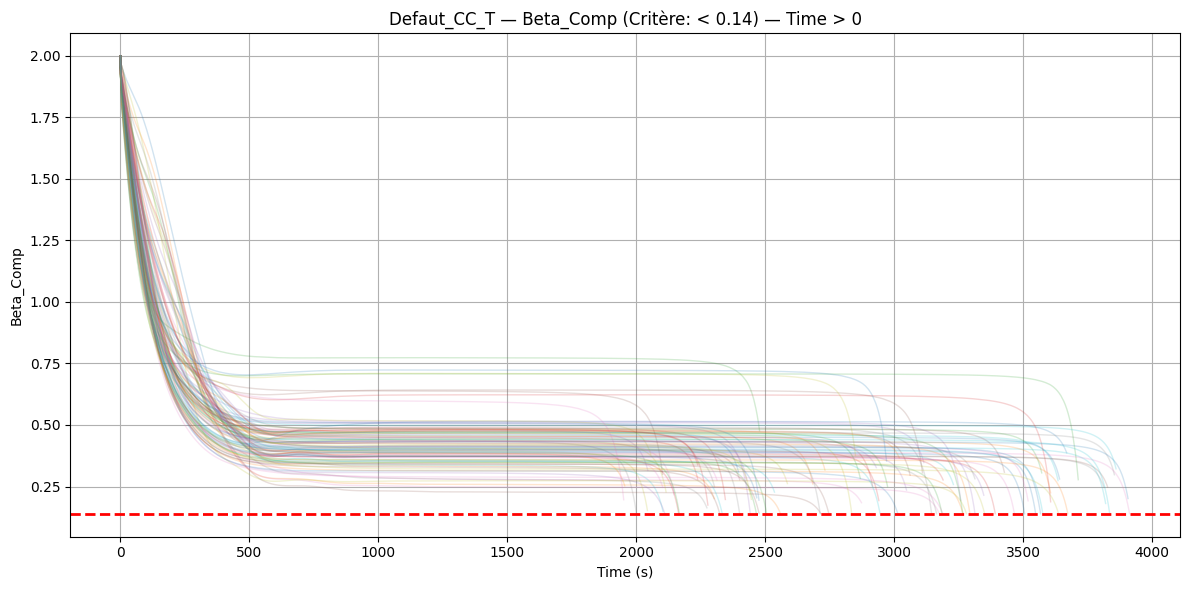

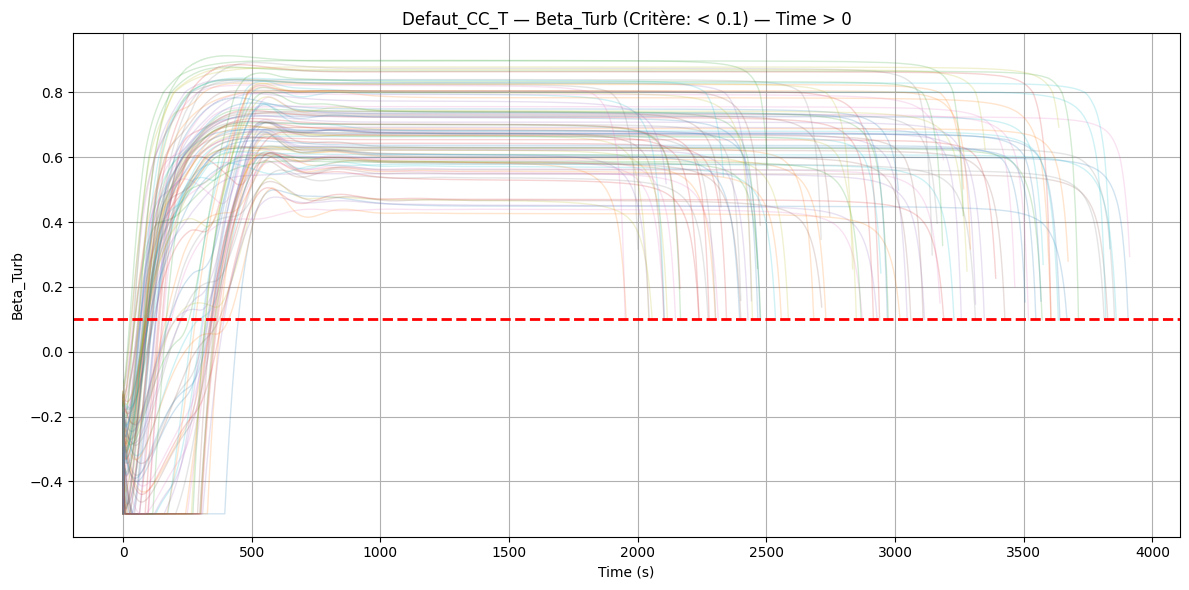

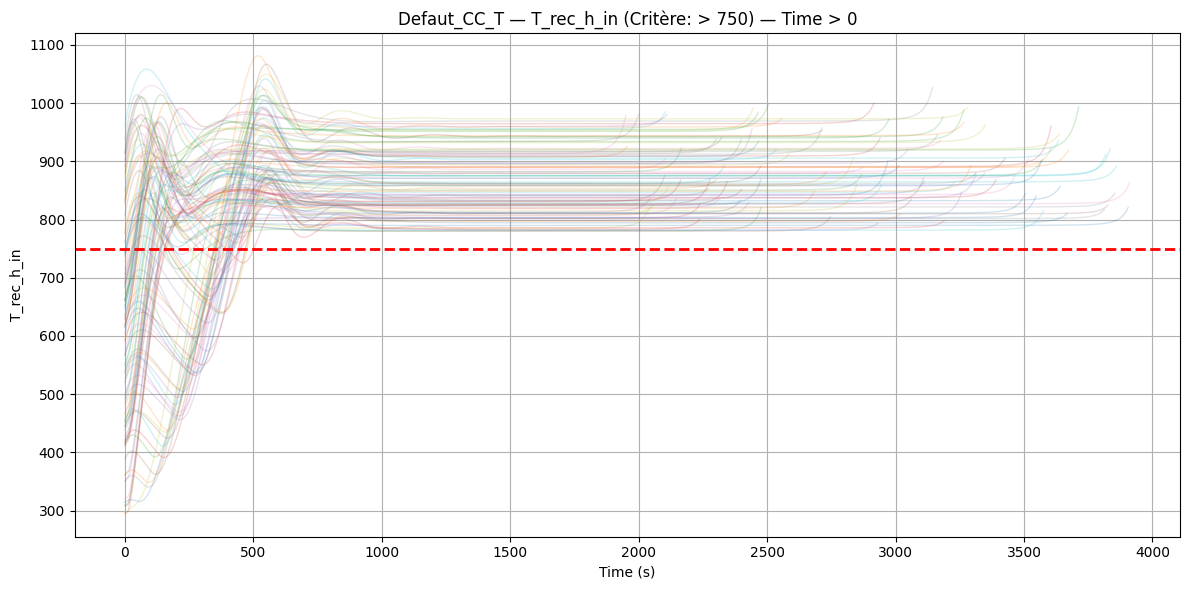


=== Dossier : Defaut_Compresseur ===
Nombre de fichiers : 100


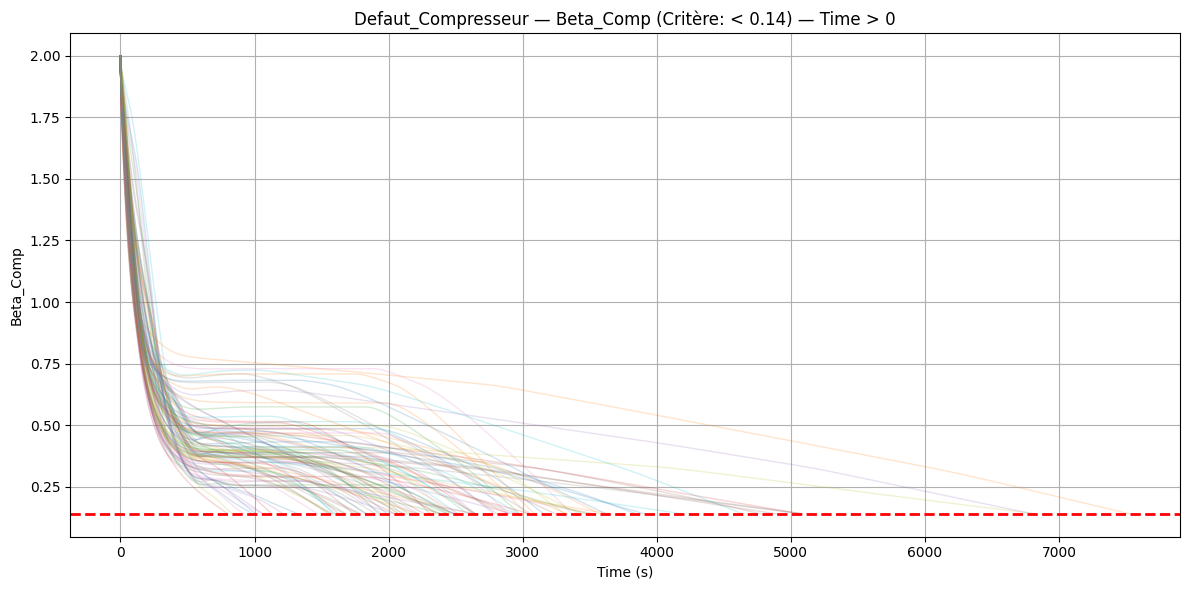

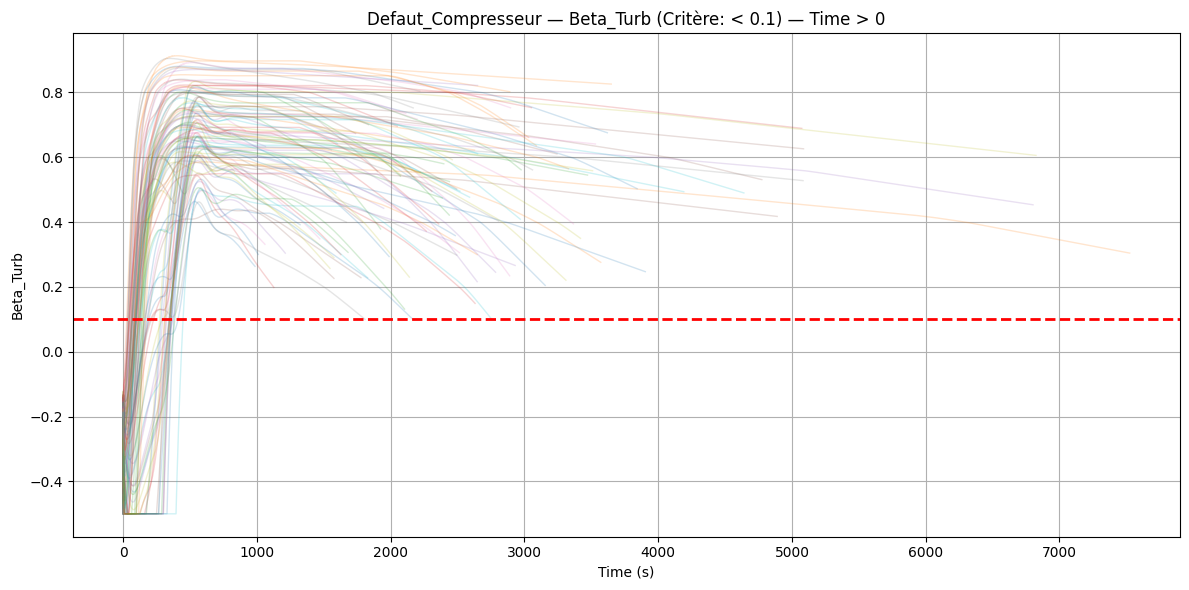

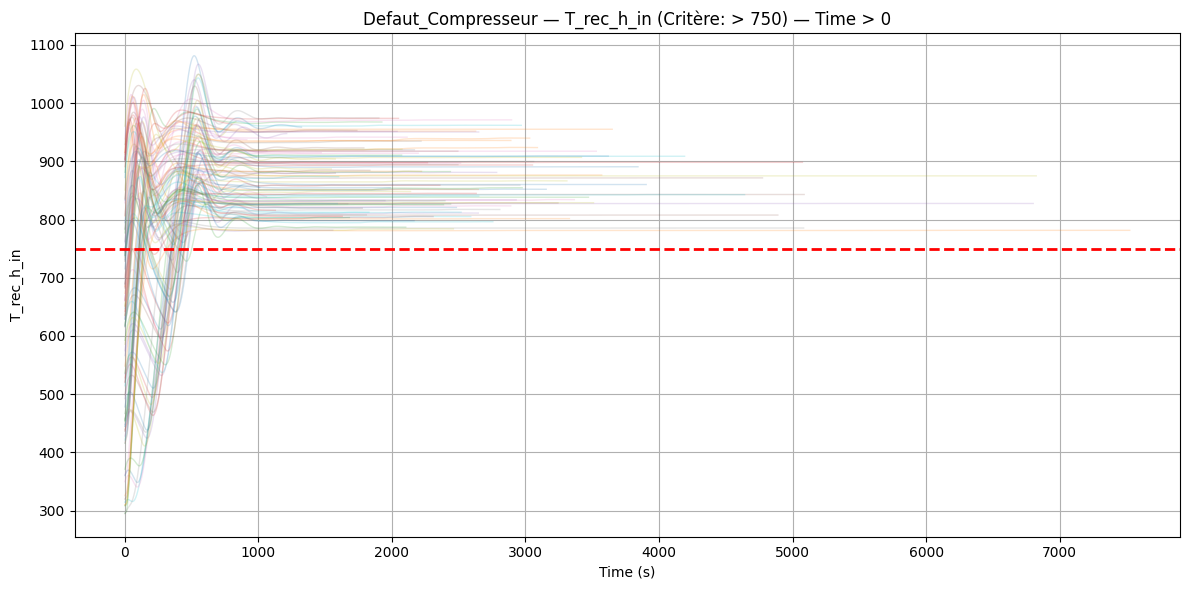


=== Dossier : Defaut_Fuite_Fuel ===
Nombre de fichiers : 99


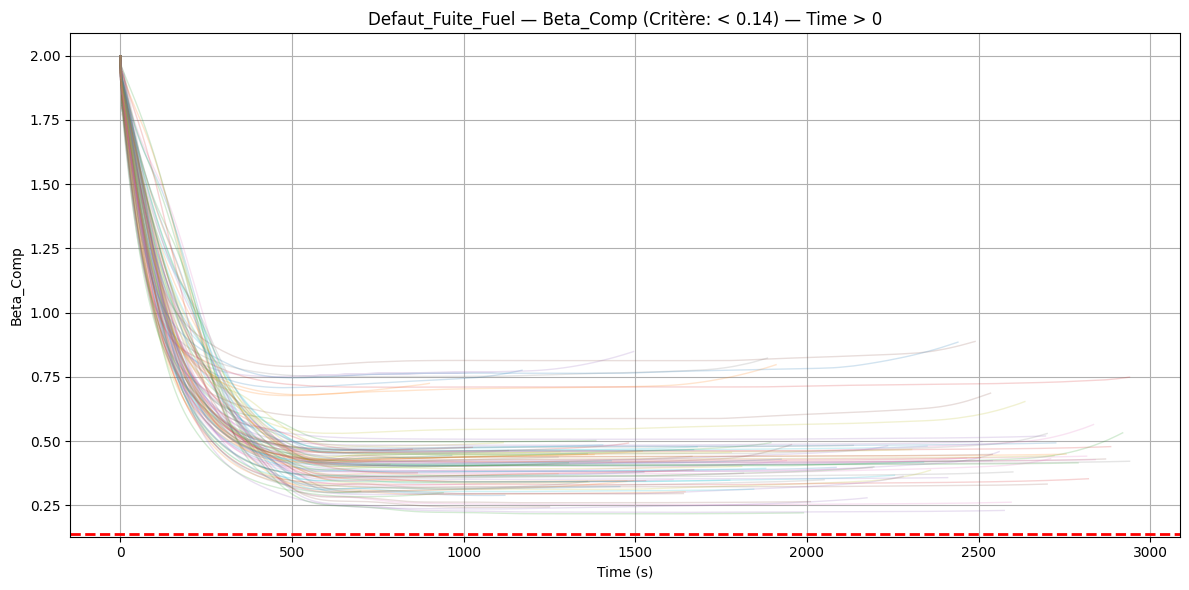

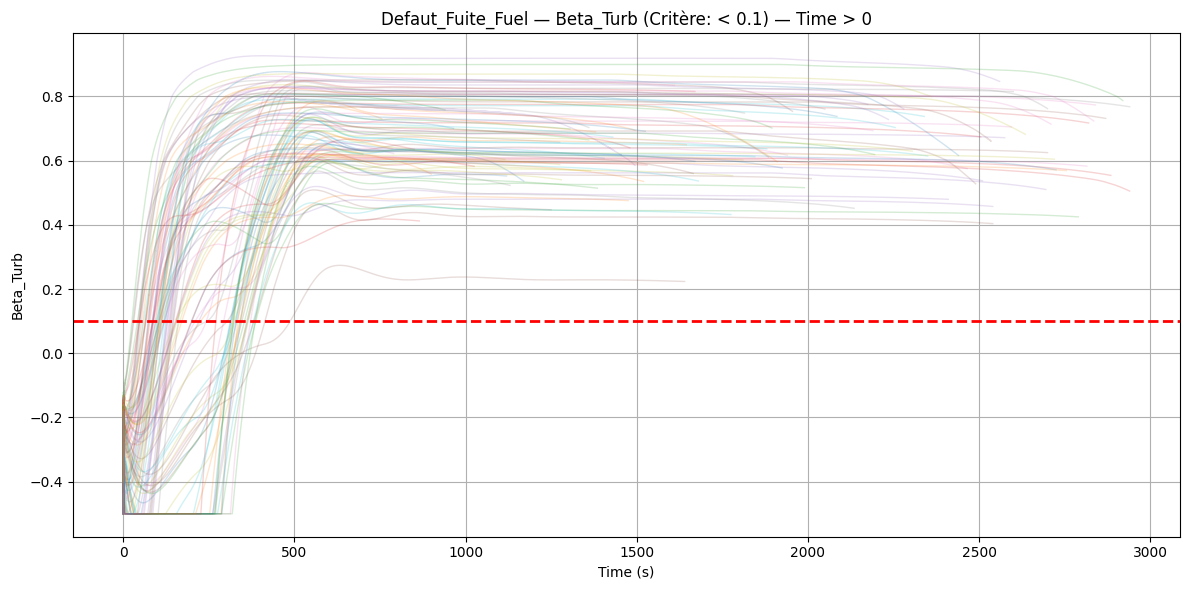

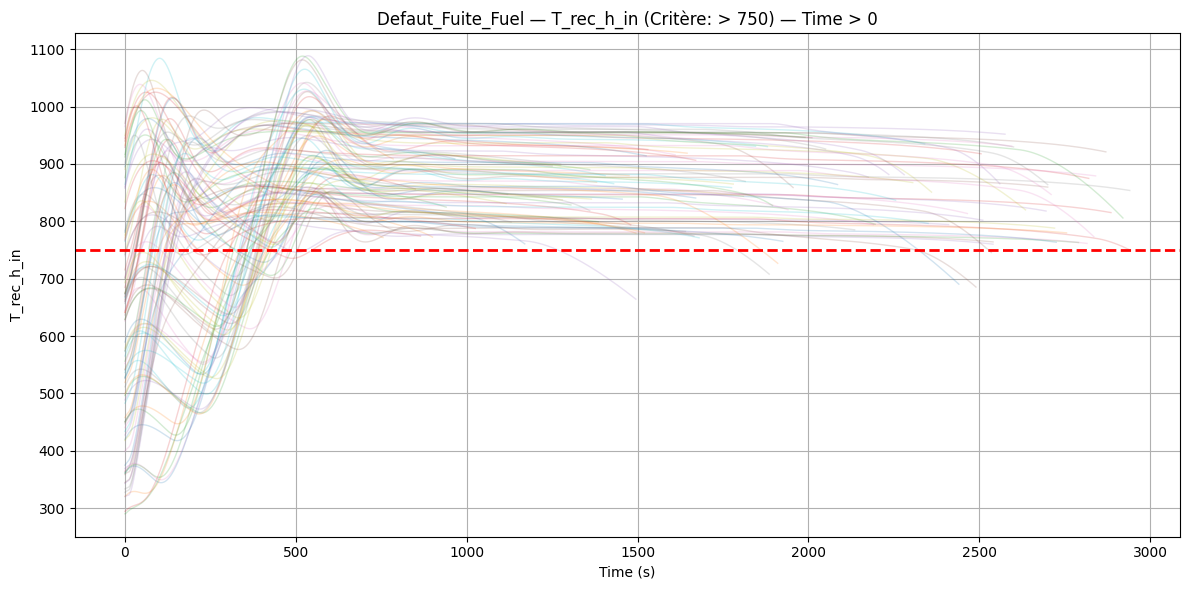


=== Dossier : Defaut_Noise_TOT ===
Nombre de fichiers : 98


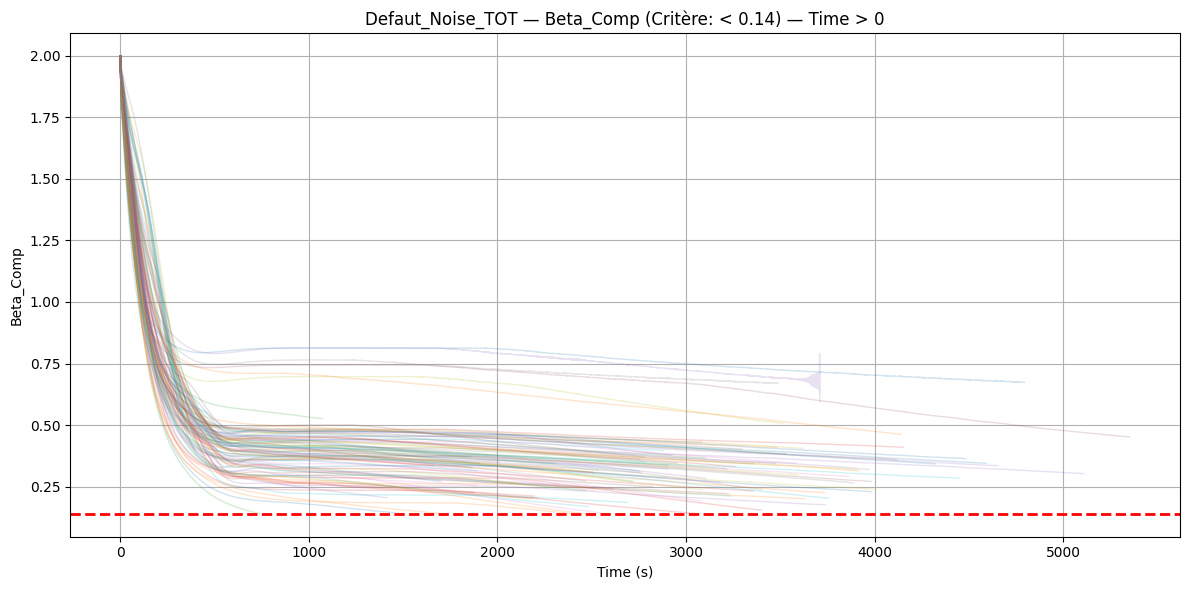

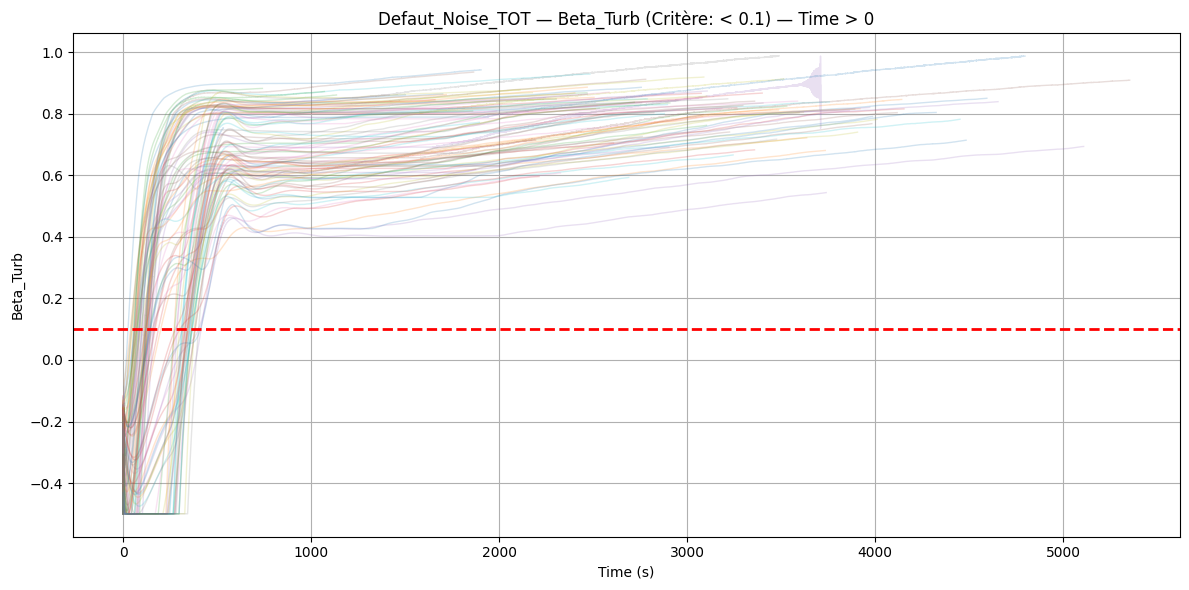

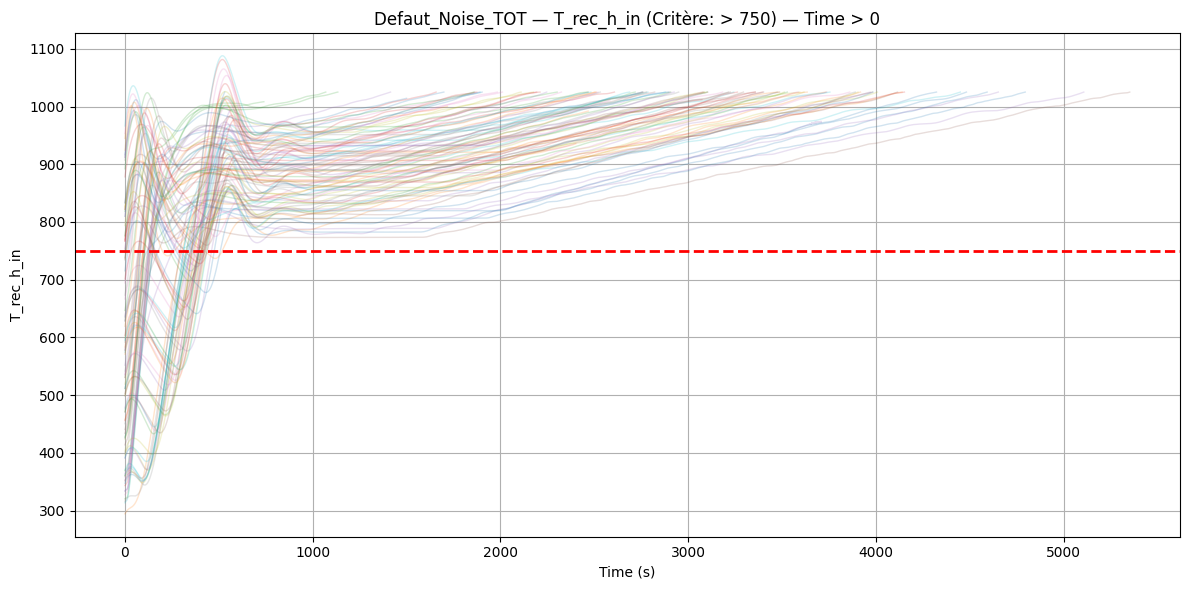


=== Dossier : Defaut_Rec_T ===
Nombre de fichiers : 100


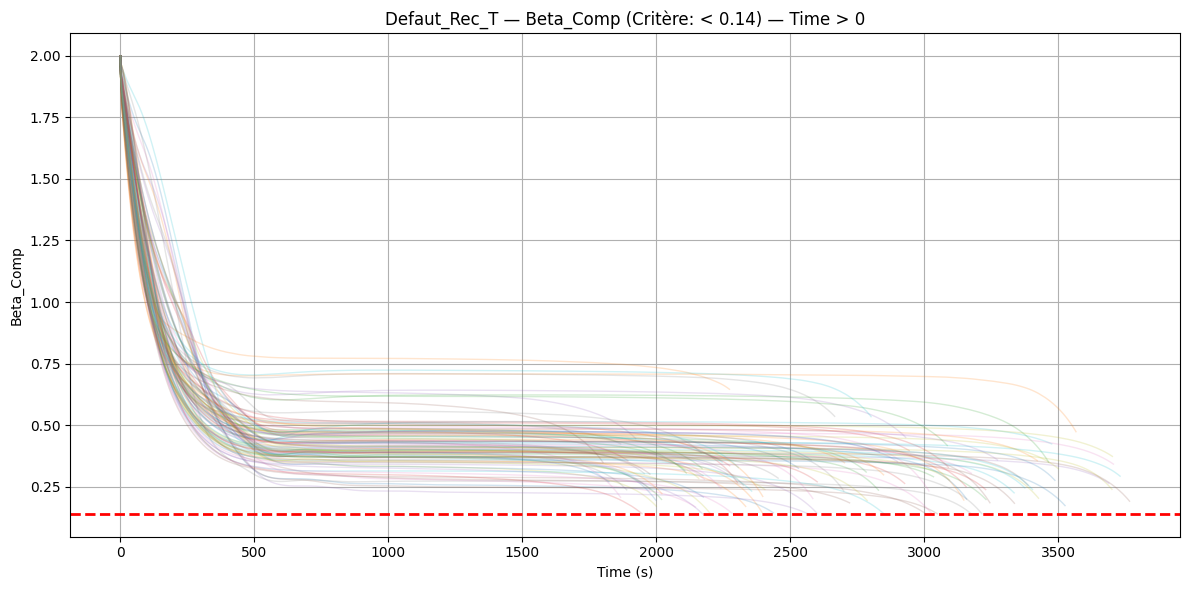

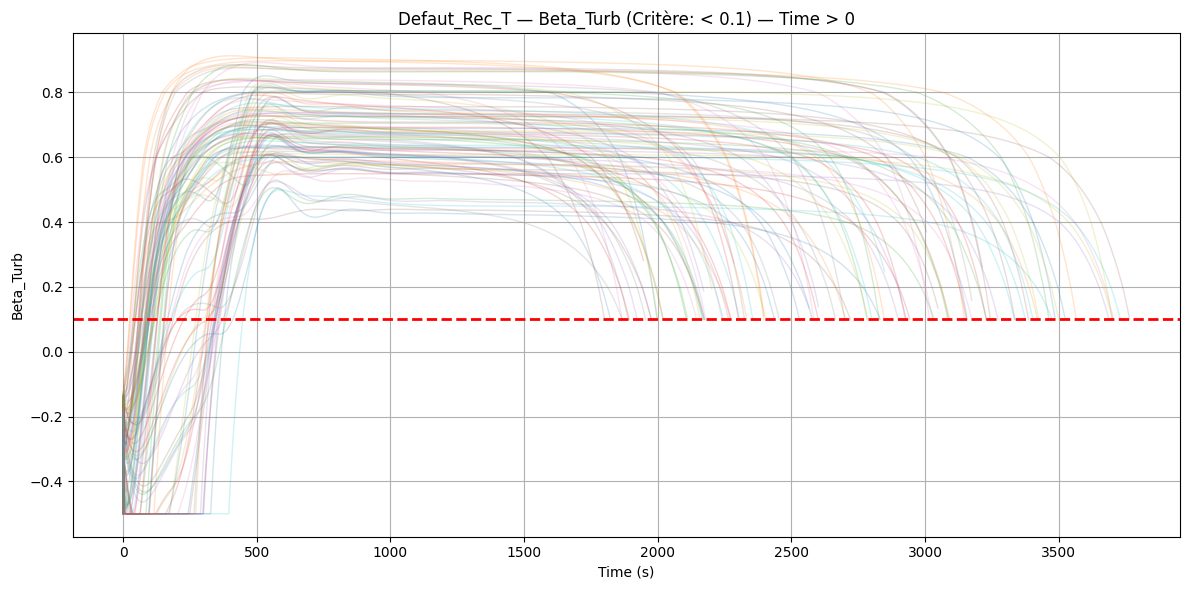

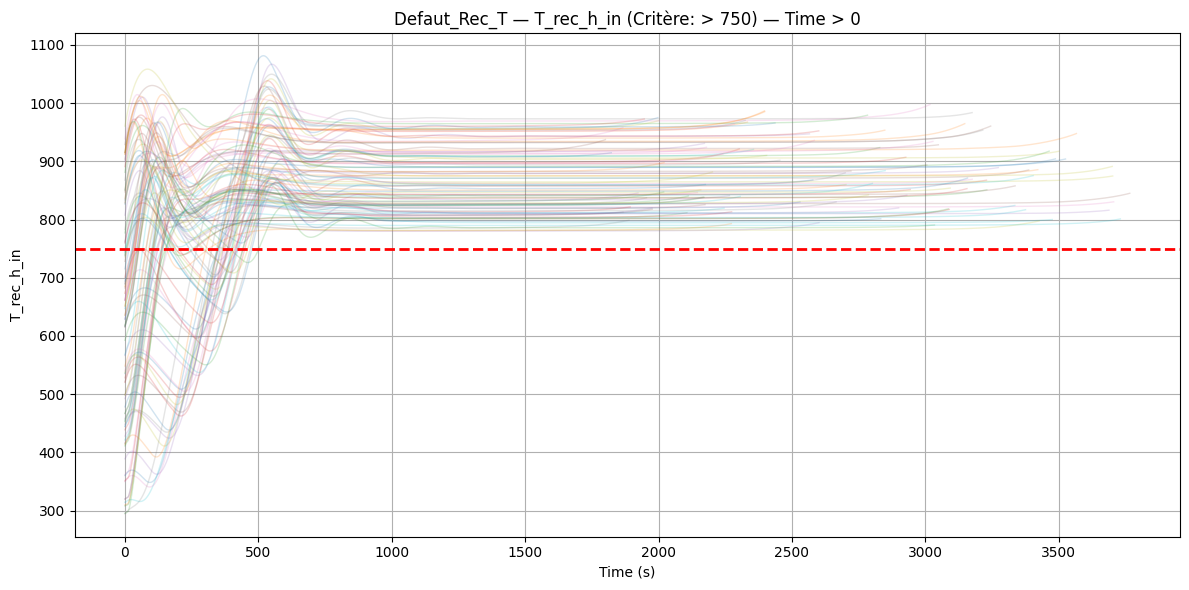


=== Dossier : Defaut_Recuperateur ===
Nombre de fichiers : 100


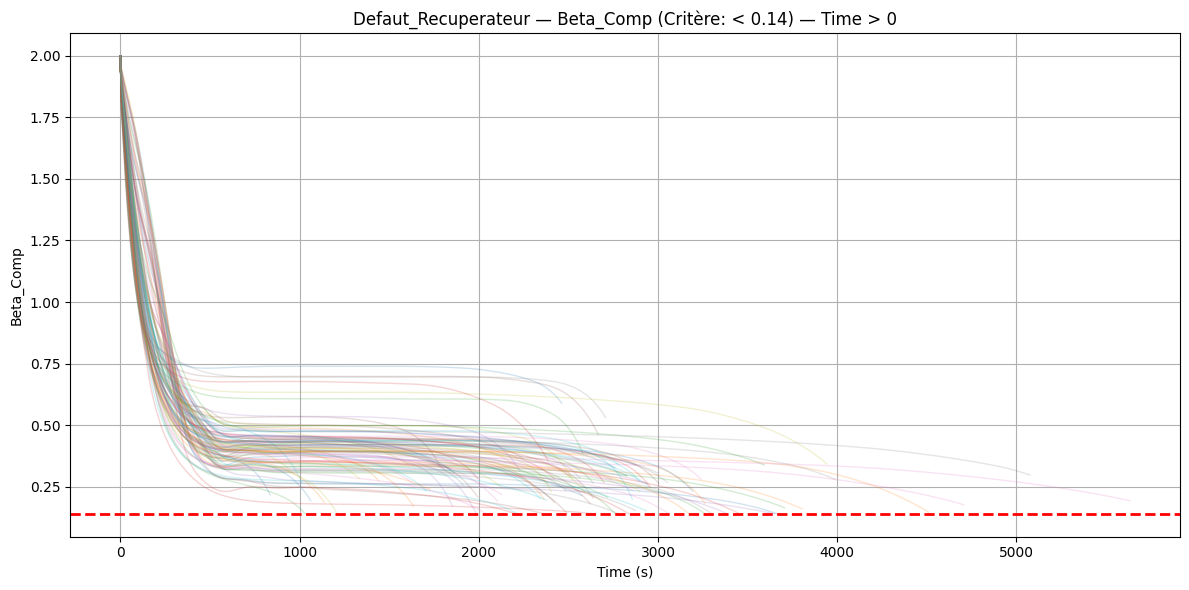

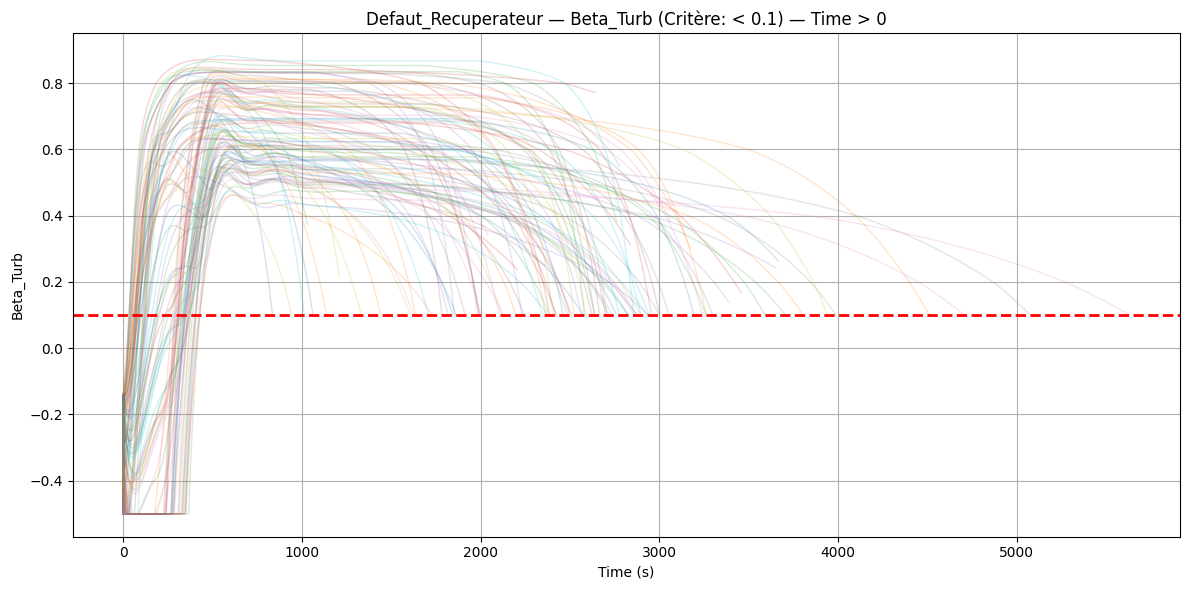

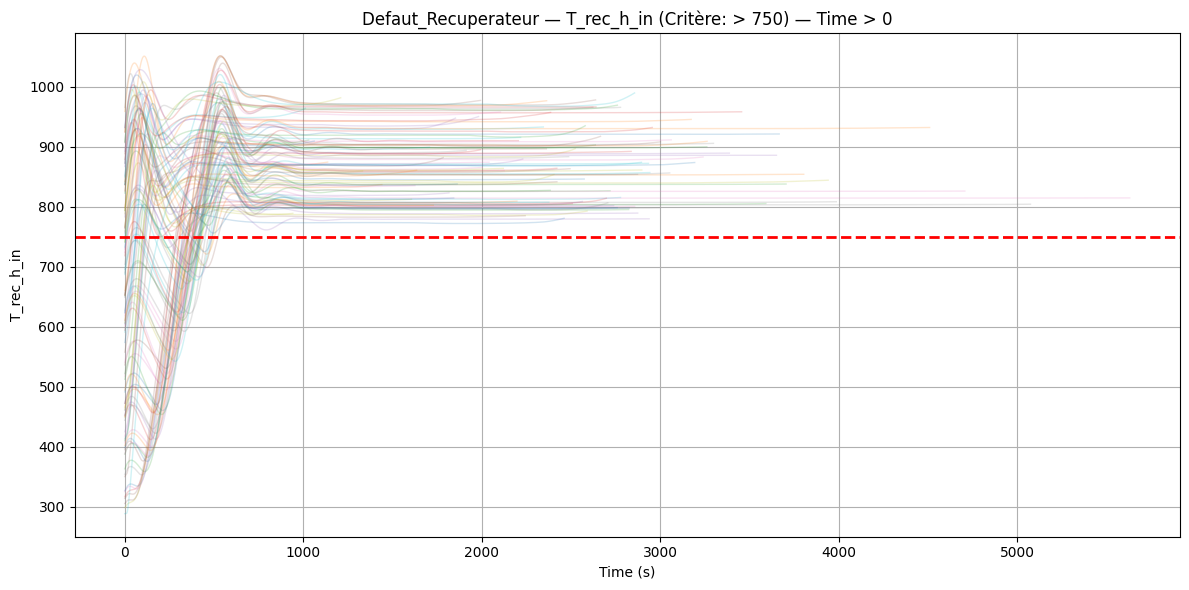


=== Dossier : Defaut_Turbine ===
Nombre de fichiers : 100


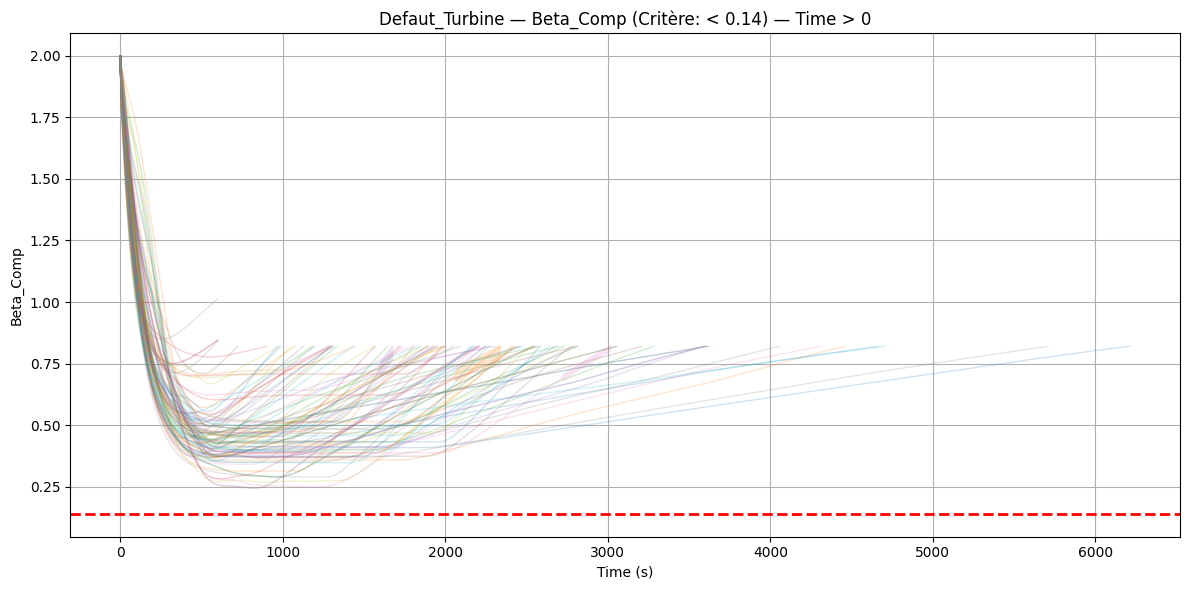

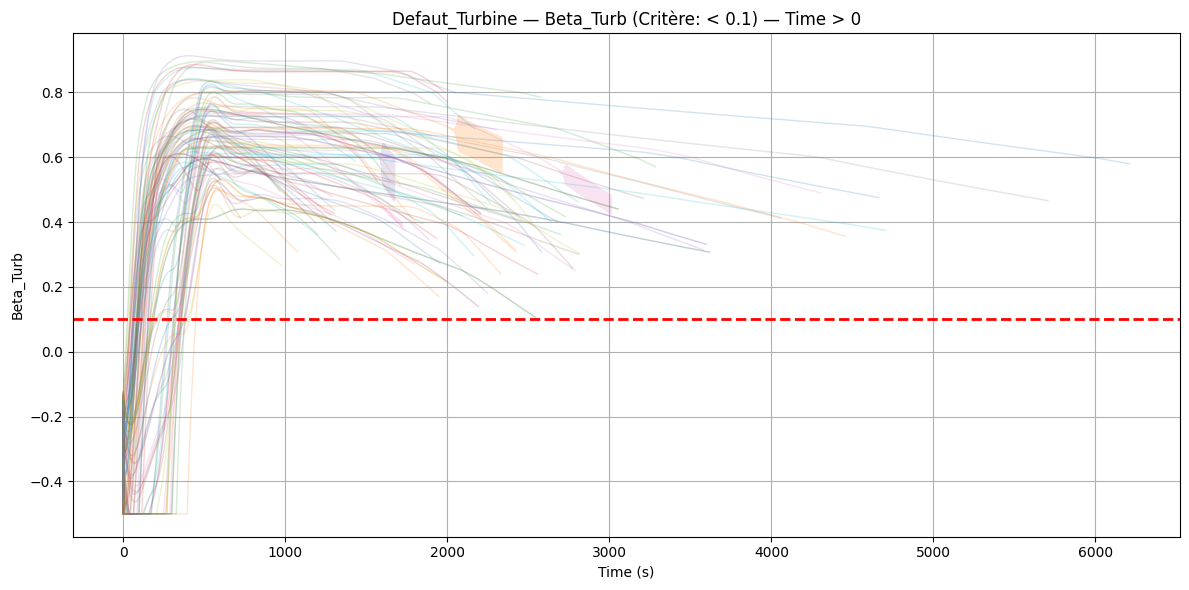

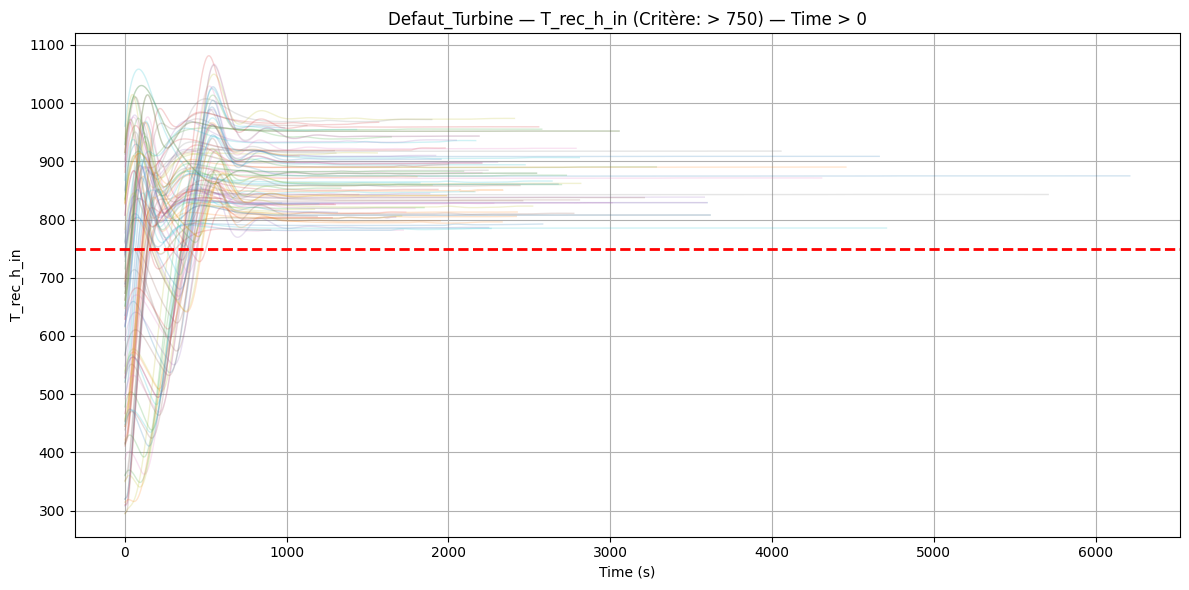


=== Dossier : FiltreAir ===
Nombre de fichiers : 100


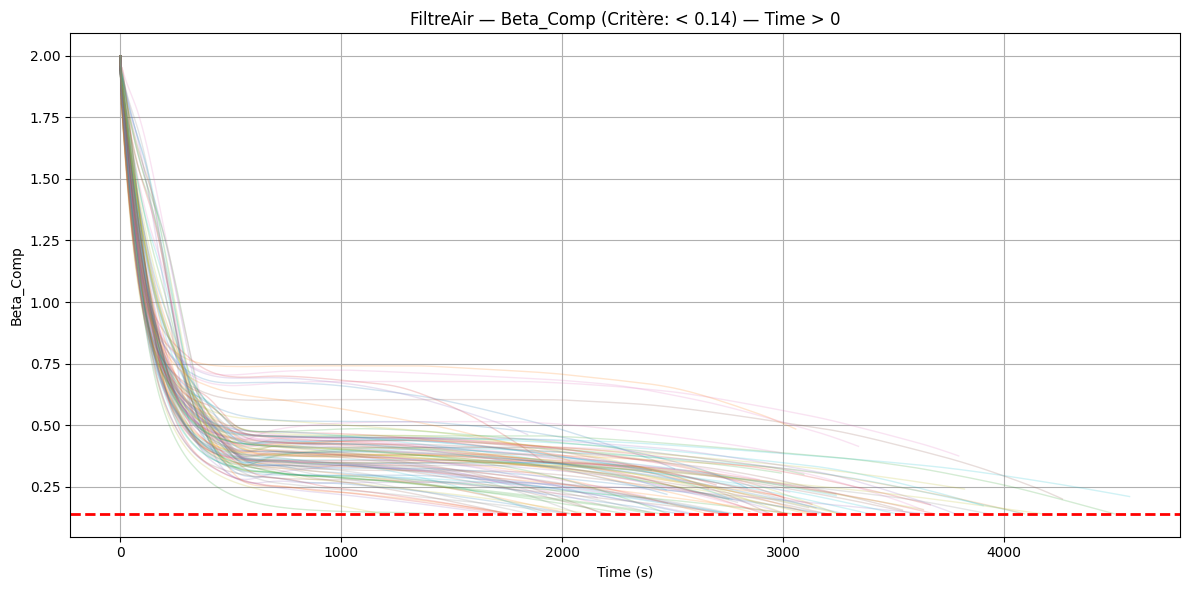

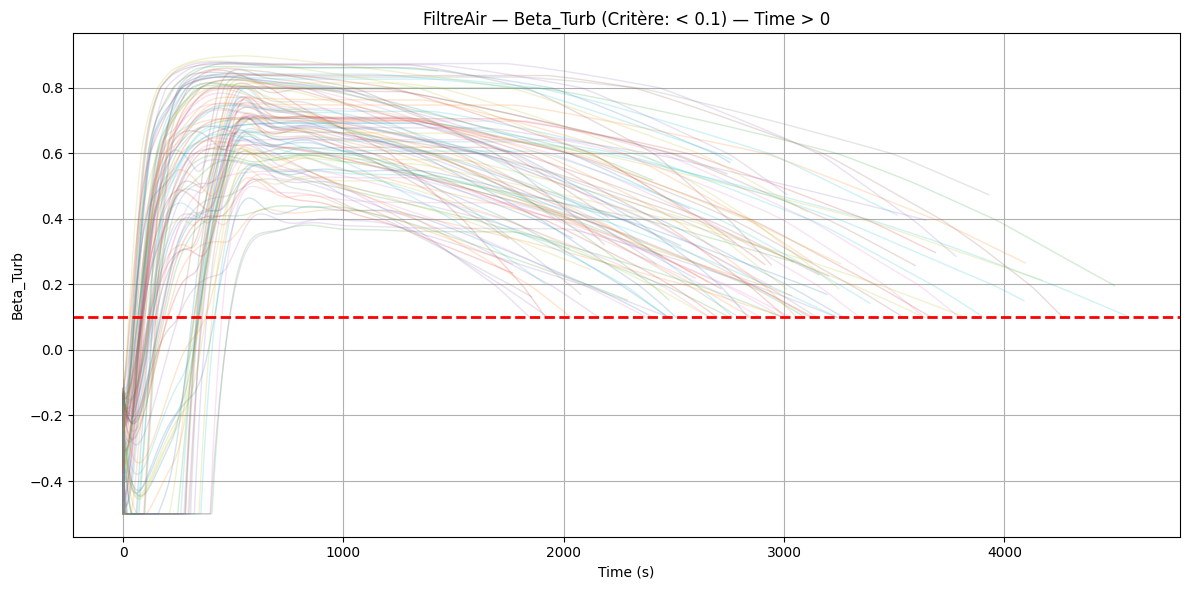

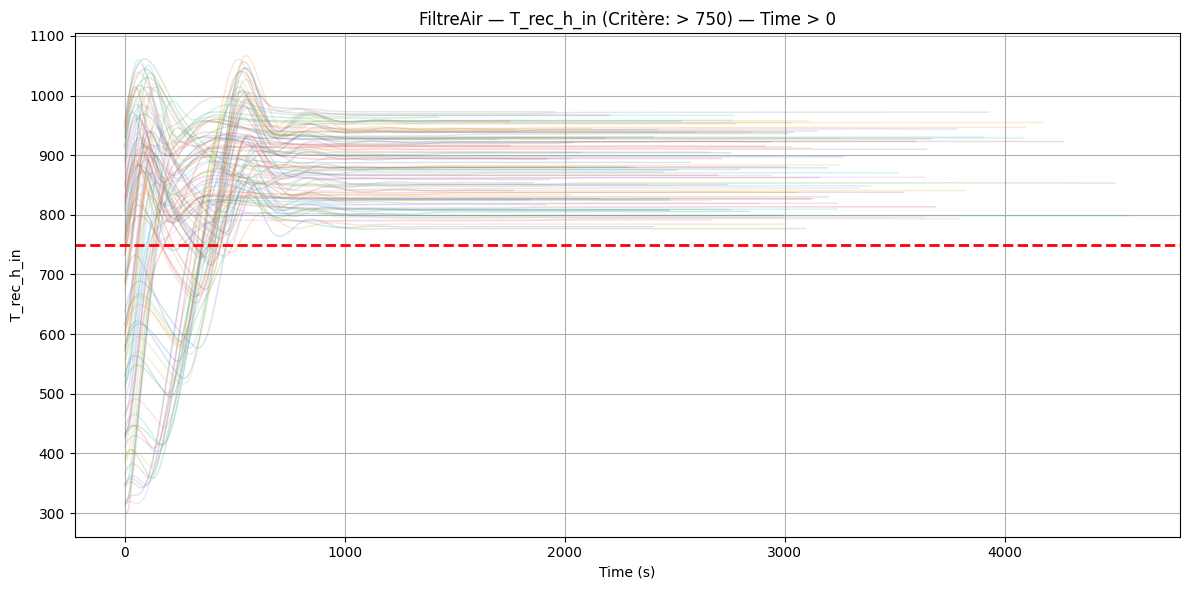


=== Dossier : Defaut_Mix ===
Nombre de fichiers : 1007


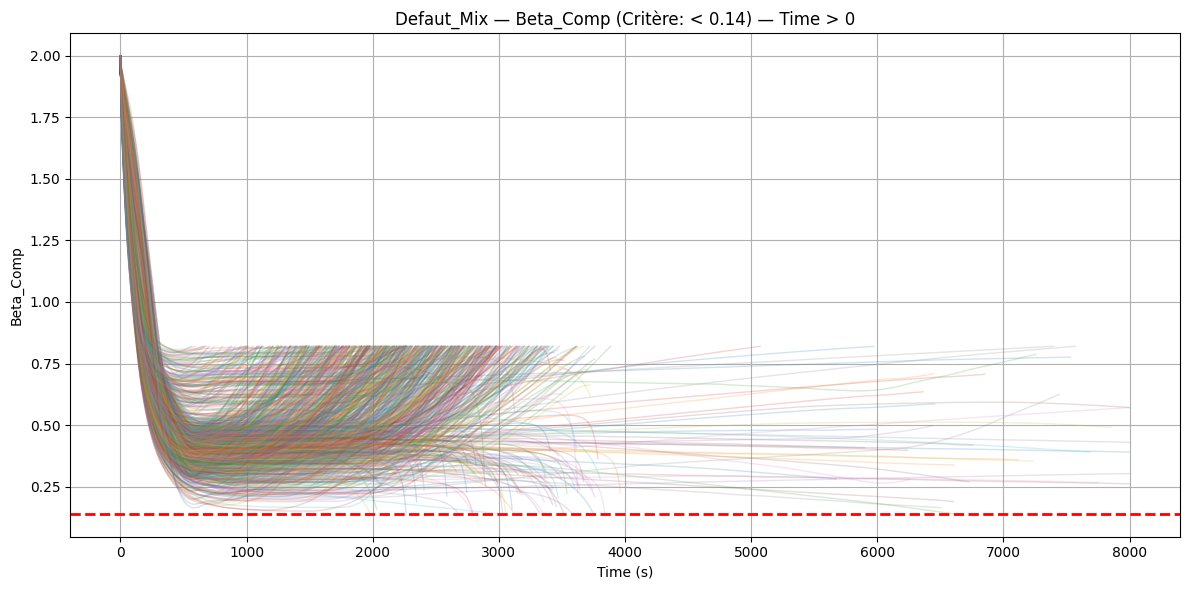

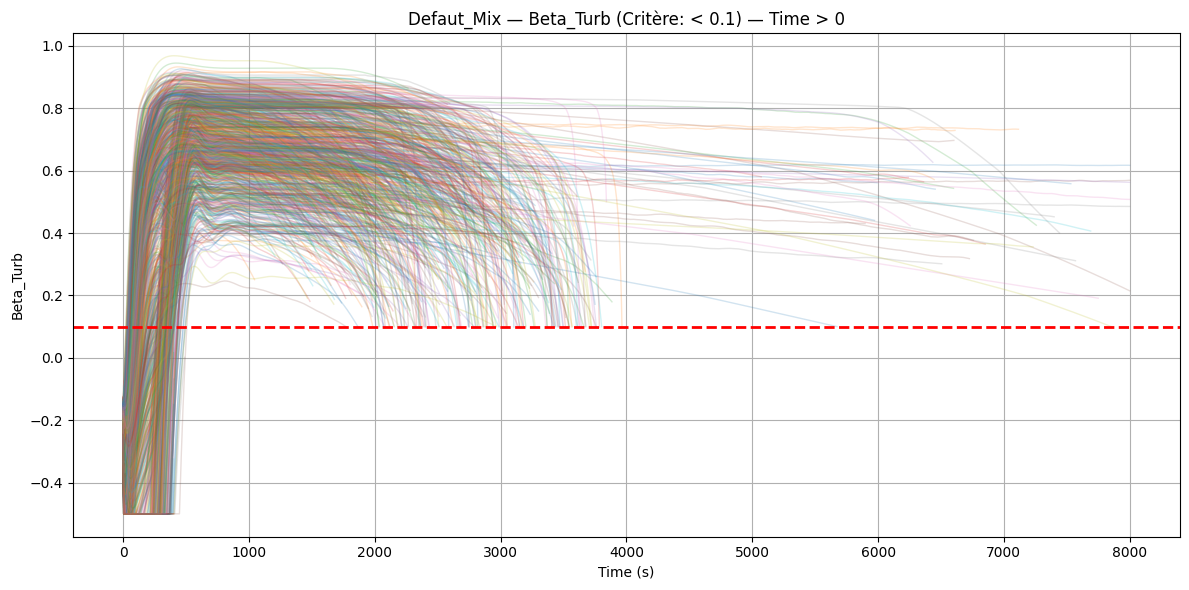

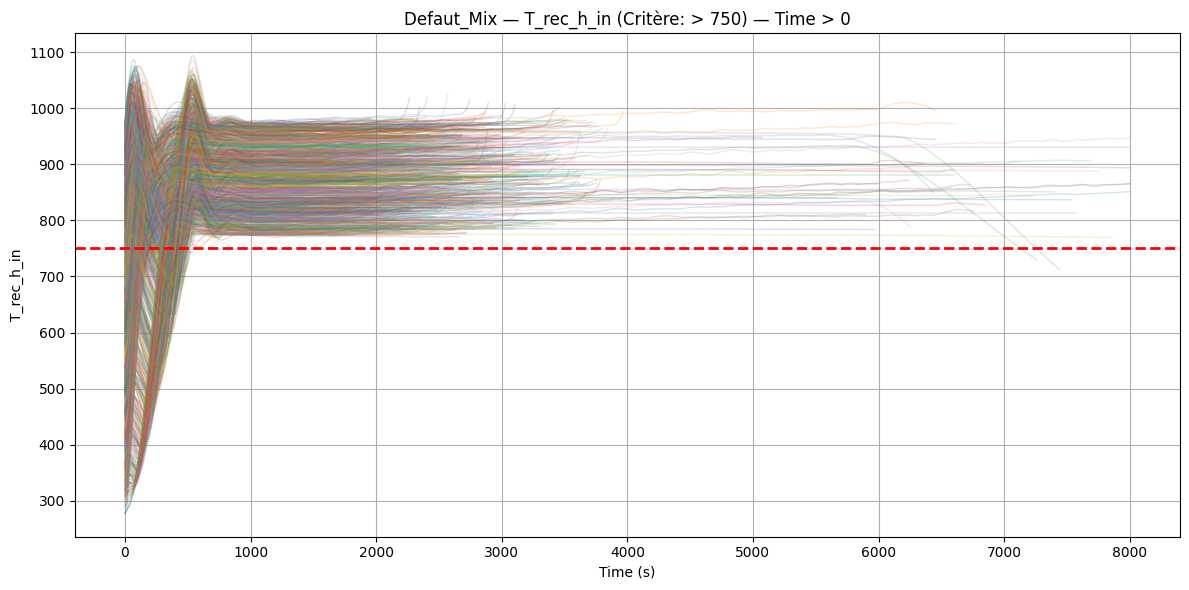

In [0]:
CRITERES_ARRET_GLOBAL = [
    ("Beta_Comp", "<", 0.14),
    ("Beta_Turb", "<", 0.1),
    ("T_rec_h_in", ">", 1023.15)
]

TIME_MIN = 0 # Seuil Time minimum pour le tracé

def plot_spaghetti_par_dossier_fast(base_dir, dossiers, criteres, time_min):
    print("\n=== VISUALISATION PAR DOSSIER : SPAGHETTI PLOTS (OPTIMISÉ) ===\n")
    
    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {dossier}")
            continue

        print(f"\n=== Dossier : {dossier} ===")

        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
        print(f"Nombre de fichiers : {len(fichiers_csv)}")

        if not fichiers_csv:
            print(f"[AVERTISSEMENT] Aucun fichier CSV dans le dossier {dossier}.")
            continue

        dataframes = []
        for fichier in fichiers_csv:
            chemin_fichier = os.path.join(path_dossier, fichier)
            try:
                df = pd.read_csv(chemin_fichier, usecols=lambda c: c in ["Time"] + [col for col, _, _ in criteres])
                if "Time" in df.columns:
                    df_filtered = df[df["Time"] > time_min]
                    if not df_filtered.empty:
                        dataframes.append(df_filtered)
            except Exception as e:
                print(f"[ERREUR] {fichier} : {e}")
                continue

        for colonne, type_test, seuil in criteres:
            plt.figure(figsize=(12, 6))
            
            for df in dataframes:
                if colonne in df.columns:
                    plt.plot(df["Time"], df[colonne], alpha=0.2, linewidth=1)
            
            plt.axhline(y=seuil, color='red', linestyle='--', linewidth=2)
            
            plt.title(f"{dossier} — {colonne} (Critère: {type_test} {seuil}) — Time > {time_min}")
            plt.xlabel("Time (s)")
            plt.ylabel(colonne)
            plt.grid(True)
            plt.tight_layout()
            
            plt.show()

plot_spaghetti_par_dossier_fast(BASE_DIR, DOSSIERS, CRITERES_ARRET_GLOBAL, TIME_MIN)


4. Répartition des fichiers contenus dans un dossier global Defaut_Tuyaux vers 4 dossiers reprenant les 4 types de fuite

In [0]:
import shutil

BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIER_SOURCE = os.path.join(BASE_DIR, "Defaut_Tuyaux")

prefix_to_folder = { # Mapping des préfixes → dossiers cibles
    "Sim_comp_rec_": os.path.join(BASE_DIR, "Defaut_Tuyaux_comp_rec"),
    "Sim_cc_t_": os.path.join(BASE_DIR, "Defaut_Tuyaux_cc_t"),
    "Sim_rec_cc_": os.path.join(BASE_DIR, "Defaut_Tuyaux_rec_cc"),
    "Sim_turb_rec_": os.path.join(BASE_DIR, "Defaut_Tuyaux_turb_rec")
}

for folder in prefix_to_folder.values():
    os.makedirs(folder, exist_ok=True)

nb_total = 0
nb_copiés = 0
nb_non_reconnus = 0

for fichier in os.listdir(DOSSIER_SOURCE):
    if not fichier.endswith(".csv"):
        continue

    nb_total += 1
    matched = False

    for prefix, folder_dest in prefix_to_folder.items():
        if fichier.startswith(prefix):
            src_path = os.path.join(DOSSIER_SOURCE, fichier)
            dest_path = os.path.join(folder_dest, fichier)

            shutil.copy2(src_path, dest_path)
            print(f"[OK] Copié : {fichier} → {folder_dest}")
            nb_copiés += 1
            matched = True
            break

    if not matched:
        print(f"[NON RECONNU] Fichier ignoré : {fichier}")
        nb_non_reconnus += 1

print("\n=== OPÉRATION TERMINÉE ===")
print(f"Total fichiers trouvés : {nb_total}")
print(f"Fichiers copiés (répartis par type) : {nb_copiés}")
print(f"Fichiers non reconnus : {nb_non_reconnus}")


[OK] Copié : Sim_cc_t_001_N_80.15_TOT_622.56_Tamb_304.12_pamb_0.97_boolFuites_0_1_0_0_startFuites_0_908_0_0_dFuites_0.001034_0.001077_0.001050_0.002056_CdFuites_0.67_0.63_0.65_0.66.csv → /Volumes/dbe_dbx_internships/justin/predictive_maintenance/Defaut_Tuyaux_cc_t
[OK] Copié : Sim_cc_t_002_N_66.26_TOT_612.41_Tamb_297.89_pamb_0.96_boolFuites_0_1_0_0_startFuites_0_1463_0_0_dFuites_0.001029_0.001036_0.001031_0.002062_CdFuites_0.67_0.64_0.67_0.69.csv → /Volumes/dbe_dbx_internships/justin/predictive_maintenance/Defaut_Tuyaux_cc_t
[OK] Copié : Sim_cc_t_003_N_91.37_TOT_641.11_Tamb_268.62_pamb_0.95_boolFuites_0_1_0_0_startFuites_0_919_0_0_dFuites_0.001004_0.001018_0.001067_0.002001_CdFuites_0.69_0.61_0.67_0.65.csv → /Volumes/dbe_dbx_internships/justin/predictive_maintenance/Defaut_Tuyaux_cc_t
[OK] Copié : Sim_cc_t_004_N_68.72_TOT_614.32_Tamb_269.26_pamb_0.99_boolFuites_0_1_0_0_startFuites_0_112_0_0_dFuites_0.001005_0.001012_0.001002_0.002035_CdFuites_0.68_0.66_0.65_0.69.csv → /Volumes/dbe_dbx_

5. Vérfication du suivi des identifiants dans les dossiers de défauts sauf Defaut_Mix

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIERS = [
    "Defaut_CC_T",
    "Defaut_Compresseur",
    "Defaut_Fuite_Fuel",
    "Defaut_Noise_TOT",
    "Defaut_Rec_T",
    "Defaut_Recuperateur",
    "Defaut_Turbine",
    "FiltreAir"#,
    #"Defaut_Mix"
]

def renommer_fichiers_consecutifs_generique(base_dir, dossiers): #Fonction de réordonnacement 
    print("\n=== RÉORDONNANCEMENT DES FICHIERS (GÉNÉRIQUE) ===\n")

    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
            continue

        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]

        if not fichiers_csv:
            print(f"{dossier} : Aucun fichier CSV trouvé.\n")
            continue

        fichiers_csv.sort()

        print(f"\n{dossier} : {len(fichiers_csv)} fichiers CSV trouvés.")

        pattern_sim = re.compile(r"Sim_(\d+)_") # Vérification des trous (on regarde juste si les noms contiennent Sim_xxx ou pas)

        trous_detectes = False
        numeros_detectes = []

        for f in fichiers_csv:
            match = pattern_sim.search(f)
            if match:
                numeros_detectes.append(int(match.group(1)))

        if numeros_detectes: # Si le pattern Sim_xxx existe → on vérifie les trous
            numeros_detectes.sort()
            for i, numero in enumerate(numeros_detectes, start=1):
                if numero != i:
                    trous_detectes = True
                    break

            if not trous_detectes:
                print(f" → Les fichiers Sim_... sont déjà consécutifs.\n")
                continue

        print(f" → Renommage en Sim_1_, Sim_2_, ... en cours...")

        # Renommage universel : Sim_1_, Sim_2_, etc. (même si le fichier d'origine n'était pas en Sim_)
        for i, ancien_nom in enumerate(fichiers_csv, start=1):
            nouveau_nom = re.sub(r"^Sim_\d+_", "", ancien_nom)  # on enlève Sim_xxx_ s'il existe
            nouveau_nom = f"Sim_{i}_" + nouveau_nom

            chemin_ancien = os.path.join(path_dossier, ancien_nom)
            chemin_nouveau = os.path.join(path_dossier, nouveau_nom)

            os.rename(chemin_ancien, chemin_nouveau)
            print(f"   RENOMMÉ : {ancien_nom} → {nouveau_nom}")

        print(f" → Renommage terminé pour {dossier}.\n")

renommer_fichiers_consecutifs_generique(BASE_DIR, DOSSIERS)



=== RÉORDONNANCEMENT DES FICHIERS (GÉNÉRIQUE) ===


Defaut_CC_T : 101 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.


Defaut_Compresseur : 100 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.


Defaut_Fuite_Fuel : 99 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.


Defaut_Noise_TOT : 98 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.


Defaut_Rec_T : 100 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.


Defaut_Recuperateur : 100 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.


Defaut_Turbine : 96 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.


FiltreAir : 100 fichiers CSV trouvés.
 → Les fichiers Sim_... sont déjà consécutifs.



6. Vérfication du suivi des identifiants pour Defaut_Mix et les autres défauts

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIERS = [
    "Defaut_CC_T",
    "Defaut_Compresseur",
    "Defaut_Fuite_Fuel",
    "Defaut_Noise_TOT",
    "Defaut_Rec_T",
    "Defaut_Recuperateur",
    "Defaut_Turbine",
    "FiltreAir",
    "Defaut_Mix"
]

def verifier_fichiers_consecutifs_generique(base_dir, dossiers):
    print("\n=== VÉRIFICATION DES FICHIERS (GÉNÉRIQUE) ===\n")

    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
            continue

        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]

        if not fichiers_csv:
            print(f"{dossier} : Aucun fichier CSV trouvé.\n")
            continue

        fichiers_csv.sort()

        print(f"\n{dossier} : {len(fichiers_csv)} fichiers CSV trouvés.")

        pattern_sim = re.compile(r"Sim(?:Longue)?[_]?(\d+)[_]?") # on cherche les fichiers qui ont Sim_xxx ou SimLongue_xxx ou Sim_xxx

        numeros_detectes = []

        for f in fichiers_csv:
            match = pattern_sim.search(f)
            if match:
                numeros_detectes.append(int(match.group(1)))

        if not numeros_detectes:
            print(f" → [INFO] Aucun numéro Sim_xxx détecté dans les noms → pas applicable.\n")
            continue

        numeros_detectes.sort()
        trous_detectes = False

        for i, numero in enumerate(numeros_detectes, start=1):
            if numero != i:
                trous_detectes = True
                break

        if trous_detectes:
            print(f" → [ALERTE] Fichiers Sim_xxx NON CONSECUTIFS ! (trous détectés)")
            print(f"   Numéros détectés : {numeros_detectes}\n")
        else:
            print(f" → [OK] Fichiers Sim_xxx consécutifs.\n")

verifier_fichiers_consecutifs_generique(BASE_DIR, DOSSIERS)



=== VÉRIFICATION DES FICHIERS (GÉNÉRIQUE) ===


Defaut_CC_T : 101 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


Defaut_Compresseur : 100 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


Defaut_Fuite_Fuel : 99 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


Defaut_Noise_TOT : 98 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


Defaut_Rec_T : 100 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


Defaut_Recuperateur : 100 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


Defaut_Turbine : 96 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


FiltreAir : 100 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.


Defaut_Mix : 1072 fichiers CSV trouvés.
 → [ALERTE] Fichiers Sim_xxx NON CONSECUTIFS ! (trous détectés)
   Numéros détectés : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 

7. Correction des identifiants pour Defaut_Mix dans un nouveau dossier

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIERS = ["Defaut_Mix"]

simulation = False  

def renommer_dans_nouveau_dossier(base_dir, dossiers, simulation=True):
    print("\n=== RENOMMAGE FICHIERS DANS NOUVEAU DOSSIER ===\n")

    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        path_dossier_new = os.path.join(base_dir, f"{dossier}_Final")

        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
            continue

        os.makedirs(path_dossier_new, exist_ok=True)

        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
        fichiers_csv.sort()

        print(f"\n{dossier} : {len(fichiers_csv)} fichiers CSV trouvés.\n")
        print(f"Les fichiers renommés seront placés dans : {path_dossier_new}\n")

        pattern_sim = re.compile(r"(Sim(?:Longue)?)_(\d+)_")

        fichiers_info = []
        for f in fichiers_csv:
            match = pattern_sim.search(f)
            if match:
                prefixe = match.group(1)  # "Sim" ou "SimLongue"
                numero = int(match.group(2))
                fichiers_info.append((f, prefixe, numero))
            else:
                print(f"[WARN] Aucun numéro détecté pour le fichier : {f}")

        fichiers_info.sort(key=lambda x: x[2])

        print("TRAITEMENT DES FICHIERS :")
        for i, (fichier, prefixe, numero_actuel) in enumerate(fichiers_info, start=1):
            nouveau_numero = i  

            nouveau_nom = re.sub(
                r"(Sim(?:Longue)?)_(\d+)_",
                f"{prefixe}_{nouveau_numero}_",
                fichier
            )

            source_path = os.path.join(path_dossier, fichier)
            target_path = os.path.join(path_dossier_new, nouveau_nom)

            if simulation:
                print(f"[SIMULATION] {fichier} → {nouveau_nom}")
            else:
                shutil.copy2(source_path, target_path)
                print(f"[COPIÉ] {fichier} → {nouveau_nom}")

        print("=" * 60 + "\n")

renommer_dans_nouveau_dossier(BASE_DIR, DOSSIERS, simulation=simulation)



=== RENOMMAGE FICHIERS DANS NOUVEAU DOSSIER ===


Defaut_Mix : 1072 fichiers CSV trouvés.

Les fichiers renommés seront placés dans : /Volumes/dbe_dbx_internships/justin/predictive_maintenance/Defaut_Mix_Final

TRAITEMENT DES FICHIERS :
[COPIÉ] SimLongue_1_SC_1367_SCOMP_0_STURB_1367_SFILT_0_SNTOT_0_SLEAK_0_SFCR_1367_SFCT_1367_SFRC_1367_SFTR_1367_SRECUP_1367_SFCC_0_SFTR2_0.csv → SimLongue_1_SC_1367_SCOMP_0_STURB_1367_SFILT_0_SNTOT_0_SLEAK_0_SFCR_1367_SFCT_1367_SFRC_1367_SFTR_1367_SRECUP_1367_SFCC_0_SFTR2_0.csv
[COPIÉ] SimLongue_2_SC_1784_SCOMP_0_STURB_1784_SFILT_1784_SNTOT_1784_SLEAK_1784_SFCR_0_SFCT_1784_SFRC_0_SFTR_0_SRECUP_1784_SFCC_0_SFTR2_0.csv → SimLongue_2_SC_1784_SCOMP_0_STURB_1784_SFILT_1784_SNTOT_1784_SLEAK_1784_SFCR_0_SFCT_1784_SFRC_0_SFTR_0_SRECUP_1784_SFCC_0_SFTR2_0.csv
[COPIÉ] SimLongue_3_SC_439_SCOMP_439_STURB_439_SFILT_439_SNTOT_439_SLEAK_0_SFCR_439_SFCT_439_SFRC_0_SFTR_439_SRECUP_439_SFCC_439_SFTR2_0.csv → SimLongue_3_SC_439_SCOMP_439_STURB_439_SFILT_439_SNTOT_439_SLEA

8. Renommage des fichiers Defaut_Mix sans le préfixe "Longue"

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIER_FINAL = "Defaut_Mix_Final"
simulation = False  # False pour renommer en vrai / Vrai pour simuler avant définitif

def supprimer_Longue_dans_Sim(base_dir, dossier, simulation=True):
    print(f"\n=== TRAITEMENT DU DOSSIER : {dossier} (SIMULATION = {simulation}) ===\n")

    path_dossier = os.path.join(base_dir, dossier)
    if not os.path.isdir(path_dossier):
        print(f"[ERREUR] Dossier inexistant : {path_dossier}")
        return

    fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
    fichiers_csv.sort()

    print(f"{len(fichiers_csv)} fichiers CSV trouvés dans {dossier}.\n")

    pattern_simlongue = re.compile(r"SimLongue_")

    for f in fichiers_csv:
        if "SimLongue_" in f:
            nouveau_nom = pattern_simlongue.sub("Sim_", f) # Nouveau nom : on remplace "SimLongue_" par "Sim_"

            source_path = os.path.join(path_dossier, f)
            target_path = os.path.join(path_dossier, nouveau_nom)

            if simulation:
                print(f"[SIMULATION] {f} → {nouveau_nom}")
            else:
                if not os.path.exists(target_path):
                    os.rename(source_path, target_path)
                    print(f"[RENOMMÉ] {f} → {nouveau_nom}")
                else:
                    print(f"[ERREUR] Cible existe déjà : {nouveau_nom} → renommage ignoré")
        else:
            print(f"[OK] {f} (ne contient pas 'SimLongue') → pas modifié.")

    print("\n=== FIN DU TRAITEMENT ===\n")

supprimer_Longue_dans_Sim(BASE_DIR, DOSSIER_FINAL, simulation=simulation)



=== TRAITEMENT DU DOSSIER : Defaut_Mix_Final (SIMULATION = False) ===

1072 fichiers CSV trouvés dans Defaut_Mix_Final.

[RENOMMÉ] SimLongue_1000_SC_1950_SCOMP_1950_STURB_1950_SFILT_1950_SNTOT_0_SLEAK_0_SFCR_1950_SFCT_0_SFRC_0_SFTR_1950_SRECUP_0_SFCC_1950_SFTR2_0.csv → Sim_1000_SC_1950_SCOMP_1950_STURB_1950_SFILT_1950_SNTOT_0_SLEAK_0_SFCR_1950_SFCT_0_SFRC_0_SFTR_1950_SRECUP_0_SFCC_1950_SFTR2_0.csv
[RENOMMÉ] SimLongue_1001_SC_658_SCOMP_0_STURB_658_SFILT_658_SNTOT_658_SLEAK_658_SFCR_658_SFCT_0_SFRC_0_SFTR_658_SRECUP_0_SFCC_0_SFTR2_0.csv → Sim_1001_SC_658_SCOMP_0_STURB_658_SFILT_658_SNTOT_658_SLEAK_658_SFCR_658_SFCT_0_SFRC_0_SFTR_658_SRECUP_0_SFCC_0_SFTR2_0.csv
[RENOMMÉ] SimLongue_1002_SC_1474_SCOMP_1474_STURB_1474_SFILT_0_SNTOT_0_SLEAK_0_SFCR_1474_SFCT_1474_SFRC_1474_SFTR_1474_SRECUP_0_SFCC_1474_SFTR2_0.csv → Sim_1002_SC_1474_SCOMP_1474_STURB_1474_SFILT_0_SNTOT_0_SLEAK_0_SFCR_1474_SFCT_1474_SFRC_1474_SFTR_1474_SRECUP_0_SFCC_1474_SFTR2_0.csv
[RENOMMÉ] SimLongue_1003_SC_1346_SCOMP_1346_ST

9. Vérification du suivi dans les fichiers Sans_Defaut

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIERS = [

    "Dossier_Sans_Defaut_Final"
]

def verifier_fichiers_consecutifs_generique(base_dir, dossiers):
    print("\n=== VÉRIFICATION DES FICHIERS (GÉNÉRIQUE) ===\n")

    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
            continue

        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]

        if not fichiers_csv:
            print(f"{dossier} : Aucun fichier CSV trouvé.\n")
            continue

        fichiers_csv.sort()

        print(f"\n{dossier} : {len(fichiers_csv)} fichiers CSV trouvés.")

        pattern_sim = re.compile(r"Sim(?:Longue)?[_]?(\d+)[_]?") # on cherche les fichiers qui ont Sim_xxx ou SimLongue_xxx ou Sim_xxx pour trouver les trous

        numeros_detectes = []

        for f in fichiers_csv:
            match = pattern_sim.search(f)
            if match:
                numeros_detectes.append(int(match.group(1)))

        if not numeros_detectes:
            print(f" → [INFO] Aucun numéro Sim_xxx détecté dans les noms → pas applicable.\n")
            continue

        numeros_detectes.sort()
        trous_detectes = False

        for i, numero in enumerate(numeros_detectes, start=1):
            if numero != i:
                trous_detectes = True
                break

        if trous_detectes:
            print(f" → [ALERTE] Fichiers Sim_xxx NON CONSECUTIFS ! (trous détectés)")
            print(f"   Numéros détectés : {numeros_detectes}\n")
        else:
            print(f" → [OK] Fichiers Sim_xxx consécutifs.\n")

verifier_fichiers_consecutifs_generique(BASE_DIR, DOSSIERS)



=== VÉRIFICATION DES FICHIERS (GÉNÉRIQUE) ===


Dossier_Sans_Defaut_Final : 3291 fichiers CSV trouvés.
 → [OK] Fichiers Sim_xxx consécutifs.



10. Renommage des fichiers de défauts tuyaux pour assurer le suivi

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIERS_TUYAUX = [
    "Defaut_Tuyaux_cc_t",
    "Defaut_Tuyaux_comp_rec",
    "Defaut_Tuyaux_rec_cc",
    "Defaut_Tuyaux_turb_rec"
]

simulation = False  # False pour faire le renommage

def extraire_numero_sim_tuyaux(nom_fichier):
    match = re.search(r"Sim_.*?_(\d{3})_N_", nom_fichier)
    if match:
        return int(match.group(1))
    else:
        return None

def renommer_ou_simuler(base_dir, dossiers, simulation=True):
    print("\n=== RENOMMAGE DES FICHIERS (SIMULATION =", simulation, ") ===\n")

    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
            continue

        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
        fichiers_csv.sort()

        print(f"\n{dossier} : {len(fichiers_csv)} fichiers CSV trouvés.\n")

        fichiers_info = []
        for f in fichiers_csv:
            numero = extraire_numero_sim_tuyaux(f)
            if numero is not None:
                fichiers_info.append((f, numero))
            else:
                print(f"[WARN] Aucun numéro détecté pour le fichier : {f}")

        fichiers_info.sort(key=lambda x: x[1])

        print("TRAITEMENT DES FICHIERS :")
        for i, (fichier, numero_actuel) in enumerate(fichiers_info, start=1):
            nouveau_numero = i
            if numero_actuel != nouveau_numero:
                nouveau_numero_str = f"{nouveau_numero:03d}"
                nouveau_nom = re.sub(r"_(\d{3})_N_", f"_{nouveau_numero_str}_N_", fichier)

                source_path = os.path.join(path_dossier, fichier)
                target_path = os.path.join(path_dossier, nouveau_nom)

                if simulation:
                    print(f"[SIMULATION] {fichier} → {nouveau_nom}")
                else:
                    if not os.path.exists(target_path):
                        os.rename(source_path, target_path)
                        print(f"[RENOMMÉ] {fichier} → {nouveau_nom}")
                    else:
                        print(f"[ERREUR] Le fichier cible existe déjà : {nouveau_nom} (renommage ignoré)")
            else:
                print(f"[OK] {fichier} (aucun changement)")

        print("=" * 60 + "\n")

renommer_ou_simuler(BASE_DIR, DOSSIERS_TUYAUX, simulation=simulation)



=== RENOMMAGE DES FICHIERS (SIMULATION = False ) ===


Defaut_Tuyaux_cc_t : 98 fichiers CSV trouvés.

TRAITEMENT DES FICHIERS :
[OK] Sim_cc_t_001_N_80.15_TOT_622.56_Tamb_304.12_pamb_0.97_boolFuites_0_1_0_0_startFuites_0_908_0_0_dFuites_0.001034_0.001077_0.001050_0.002056_CdFuites_0.67_0.63_0.65_0.66.csv (aucun changement)
[OK] Sim_cc_t_002_N_66.26_TOT_612.41_Tamb_297.89_pamb_0.96_boolFuites_0_1_0_0_startFuites_0_1463_0_0_dFuites_0.001029_0.001036_0.001031_0.002062_CdFuites_0.67_0.64_0.67_0.69.csv (aucun changement)
[OK] Sim_cc_t_003_N_91.37_TOT_641.11_Tamb_268.62_pamb_0.95_boolFuites_0_1_0_0_startFuites_0_919_0_0_dFuites_0.001004_0.001018_0.001067_0.002001_CdFuites_0.69_0.61_0.67_0.65.csv (aucun changement)
[OK] Sim_cc_t_004_N_68.72_TOT_614.32_Tamb_269.26_pamb_0.99_boolFuites_0_1_0_0_startFuites_0_112_0_0_dFuites_0.001005_0.001012_0.001002_0.002035_CdFuites_0.68_0.66_0.65_0.69.csv (aucun changement)
[OK] Sim_cc_t_005_N_63.91_TOT_681.61_Tamb_268.55_pamb_0.97_boolFuites_0_1_0_0_startFui

11. Vérification du renommage des fichiers défaut tuyaux

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIERS_TUYAUX = [
    "Defaut_Tuyaux_cc_t",
    "Defaut_Tuyaux_comp_rec",
    "Defaut_Tuyaux_rec_cc",
    "Defaut_Tuyaux_turb_rec"
]

def extraire_numero_sim_tuyaux(nom_fichier):
    match = re.search(r"Sim_.*?_(\d{3})_N_", nom_fichier) # Expression régulière Regex : Sim_xxx_YYY_N_... → on récupère YYY
    if match:
        return int(match.group(1))
    else:
        return None

def verifier_numeros_tuyaux(base_dir, dossiers):
    print("\n=== VÉRIFICATION DES NUMÉROS DE SIMULATION (TUYAUX) ===\n")

    for dossier in dossiers:
        path_dossier = os.path.join(base_dir, dossier)
        if not os.path.isdir(path_dossier):
            print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
            continue

        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
        fichiers_csv.sort()

        print(f"\n{dossier} : {len(fichiers_csv)} fichiers CSV trouvés.\n")

        numeros_sim = []
        for f in fichiers_csv:
            numero = extraire_numero_sim_tuyaux(f)
            if numero is not None:
                numeros_sim.append(numero)
            else:
                print(f"[WARN] Aucun numéro détecté pour le fichier : {f}")

        if numeros_sim:
            numeros_sim.sort()
            print(f"Numéros extraits : {numeros_sim}\n")
            manquants = [i for i in range(1, max(numeros_sim) + 1) if i not in numeros_sim]
            if manquants:
                print(f"[ALERTE] Numéros manquants : {manquants}\n")
            else:
                print("[OK] Aucun numéro manquant.\n")
        else:
            print("[ERREUR] Aucun numéro extrait pour ce dossier.\n")

        print("=" * 50 + "\n")

verifier_numeros_tuyaux(BASE_DIR, DOSSIERS_TUYAUX)



=== VÉRIFICATION DES NUMÉROS DE SIMULATION (TUYAUX) ===


Defaut_Tuyaux_cc_t : 98 fichiers CSV trouvés.

Numéros extraits : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]

[OK] Aucun numéro manquant.



Defaut_Tuyaux_comp_rec : 100 fichiers CSV trouvés.

Numéros extraits : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 